## Morphological counts

 Q2: clinical data vs. morphology
1) Compute systematically associations between clinical variables and morphological cluster counts. The purpose is to compare the magnitude of the associations of the different variables with morphology.
2) Discuss the association with technical variables.
3) For non-technical variables, redo the analysis with adjustment for the confounding technical variables, if any is reported in Q2.2. Report and discuss significant associations.

In [ ]:
#Installs and imports
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("DESeq2")
install.packages("corrplot")

In [1]:
library("DESeq2")
library(ggplot2)
library(corrplot)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows


Loading required package: GenomicRanges

Loading required p

In [2]:
#load data
clinical_data = read.delim(file='clinical-data.tsv',sep ='\t',header=TRUE,row.names=1)
#DTHHRDY is a categorical variable, set its type to character to that it can be viewed as such by deseq2
clinical_data$DTHHRDY <- as.character(clinical_data$DTHHRDY)

morph_counts = t(read.delim(file='morphological-counts.tsv', sep='\t', header=TRUE, row.names=1))
#Take out "Morphological.cluster" from column names for brevity's sake
row.names(morph_counts) = gsub("Mophological.cluster.", "", row.names(morph_counts))
head(morph_counts)

,GTEX-1122O-0226,GTEX-1128S-0126,GTEX-113JC-0126,GTEX-11DXX-0226,GTEX-11EM3-0126,GTEX-11EMC-0226,GTEX-11GSP-0126,GTEX-11I78-0526,GTEX-11P81-0126,GTEX-11TTK-0826,⋯,GTEX-1PBJI-0726,GTEX-1QCLZ-0626,GTEX-1QEPI-0726,GTEX-1QP28-0626,GTEX-1QP67-0326,GTEX-1QPFJ-0626,GTEX-1R46S-0426,GTEX-1R9JW-0226,GTEX-1RDX4-0926,GTEX-1S5ZU-0726
0,171,198,175,79,20,24,60,49,86,211,⋯,90,24,57,17,242,10,240,28,304,134
1,133,60,95,52,22,35,680,23,189,277,⋯,194,13,35,89,172,26,71,35,221,203
2,105,131,73,144,107,161,369,113,40,87,⋯,177,126,166,135,15,54,101,186,235,11
3,235,345,160,20,74,50,0,92,52,261,⋯,262,16,44,41,126,18,279,3,412,251
4,13,261,48,30,49,233,10,23,10,84,⋯,449,51,260,68,11,19,81,33,131,7
5,399,332,163,177,589,84,9,178,53,27,⋯,31,197,23,238,106,313,501,114,196,8


Automatically generates interesting plots in function of var. All plots are saved under morph_plots/ and file names end in the variable name. In case of a categorical variable, there are some extra plots that can begenerated lile plotCounts and volcano plot. These are not interesting. for the other variables because they are typically made in a "cancer/no cancer" type situation, this can be an interesting style of analysis for e.g. postmortem/donor, but not for weight or height.

In [18]:
morph_analysis <- function(var, formula, categorical, confounding=FALSE) {
  
  #construct DESEQDataset object
  #we don't normalize the counts since the tutorial from bioconductor
  #says deseq2 does not expect that: 
  #https://www.bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#why-un-normalized-counts
  
  #dds holds the read counts. The design formula expresses the variables
  #which will be used in modeling, it is used to estimate the dispersion
  #and to estimate the log2 fold changes of the model
  
  #We will not be pre-filtering low count clusters since we are only working
  #with 64 clusters instead of hundreds or thousands of genes
  #https://www.bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pre-filtering
  dds = DESeqDataSetFromMatrix(countData = morph_counts, 
                               colData = clinical_data,
                               design = formula)
  #Run DESeq function
  dds = DESeq(dds)
  res = results(dds)
  #summary of the differential morphology expression
  summary(res)
  
  #Plotting adjusted p-values for each morphological cluster
  #We will go with the default cutoff value 0.1 for padj
  #https://www.bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#p-values-and-adjusted-p-values
  #The more dots below the line, the more clusters are significantly linked
  #to the chosen clinical/technical variable(s)
  plot(rownames(morph_counts),xlab = "mean of normalized counts", ylab = "log fold change", cex.lab = 1.5, res$padj)
  abline(h=0.1, col="red")
  
  #Normalized counts of cluster
  #Shows the log2 fold changes attributable to a given variable over the mean
  #of normalized counts for all the samples in the data set
  #https://www.bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#ma-plot
  plotMA(res)
  #TODO: bigger dots
  
  #sort results by p-value
  res <- na.omit(res[order(res$padj),])
  
  #Save list of most significant clusters
  #cutoff: padj has to be smaller than 0.1
  sign_clusters = res[res$padj < 0.1,]
  if (confounding) {
      write.csv(sign_clusters, paste("Morph_plots/cluster_lists/lowest_padj_",var,"_confounding.csv",sep=""))
  } else {
      write.csv(sign_clusters, paste("Morph_plots/cluster_lists/lowest_padj_",var,".csv",sep=""))
  }
  print(sign_clusters)
  
  #Plot the counts of the clusters with the 10 lowest adjusted p-values, one plot per cluster
  #https://www.bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#plot-counts
  if (categorical) {
    clusters = rownames(head(res,10))
    for (cluster in clusters) {
      plotCounts(dds, gene=cluster, intgroup=var, main=paste("Cluster ",cluster,sep=""))
    }
  }
  
  #Volcano plot
  #Blue = padj < 0.1
  #Red = padj < 0.1 and fold change > 2
  #https://en.wikipedia.org/wiki/Volcano_plot_(statistics)
  par(mfrow=c(1,1))
  with(res, plot(log2FoldChange, -log10(pvalue), pch=19, main=paste("Volcano plot ", var,sep=""), xlim=c(-3,3)))
  with(subset(res, padj<.01 ), points(log2FoldChange, -log10(pvalue), pch=19, col="blue"))
  with(subset(res, padj<.01 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=19, col="red"))
  legend(x="topright", 
         legend=c("Padj > 0.1", "Padj < 0.1", "Padh < 0.1 and log2FC > 2"),
         col=c("black", "blue", "red"),
         pch=19)
 
  
  #PCA
  #TODO???
}

### Q2.1 - Clinical variables vs. morphology

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting 


out of 64 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 16, 25%
LFC < 0 (down)     : 17, 27%
outliers [1]       : 2, 3.1%
low counts [2]     : 0, 0%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



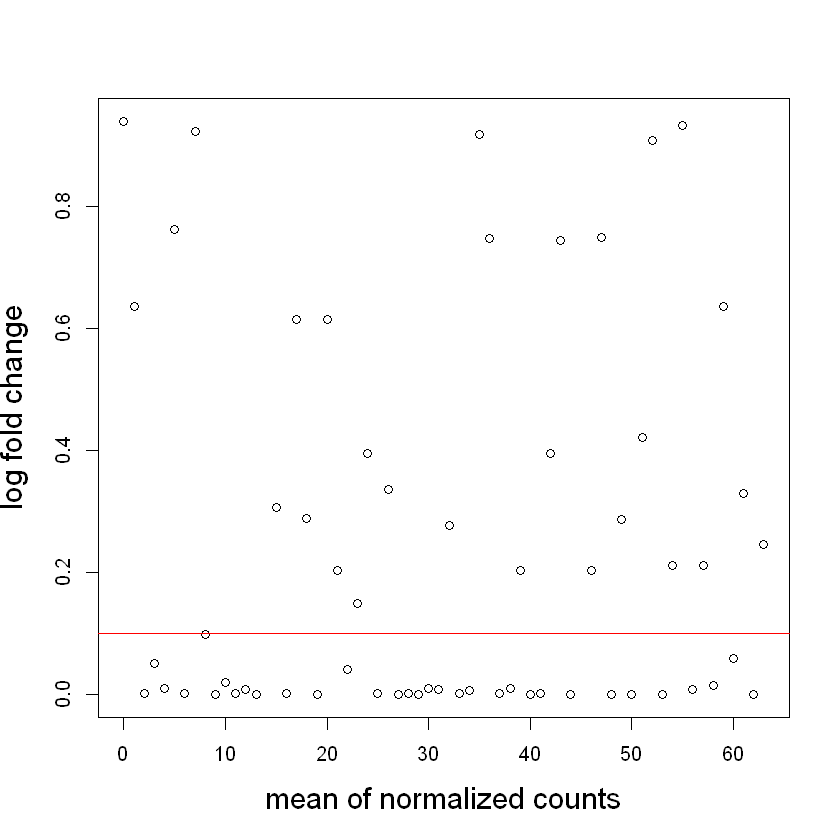

log2 fold change (MLE): AGE 
Wald test p-value: AGE 
DataFrame with 33 rows and 6 columns
     baseMean log2FoldChange      lfcSE      stat      pvalue        padj
    <numeric>      <numeric>  <numeric> <numeric>   <numeric>   <numeric>
44   172.3732      0.0397693 0.00719482   5.52749 3.24849e-08 2.01407e-06
40   182.7025      0.0605038 0.01141546   5.30016 1.15701e-07 3.58673e-06
50   188.2888      0.0570618 0.01102518   5.17559 2.27195e-07 4.69537e-06
53    92.9895     -0.0401842 0.00809008  -4.96709 6.79646e-07 1.05345e-05
62   104.8641     -0.0489837 0.01059072  -4.62515 3.74319e-06 4.64155e-05
...       ...            ...        ...       ...         ...         ...
10    93.3999     -0.0257011 0.00992884  -2.58853  0.00963868   0.0206068
22    31.5082     -0.0307420 0.01322763  -2.32407  0.02012158   0.0415846
3    110.1487     -0.0201276 0.00902577  -2.23001  0.02574649   0.0514930
60   156.7795      0.0182298 0.00842876   2.16280  0.03055621   0.0592027
8    121.9710      0.0

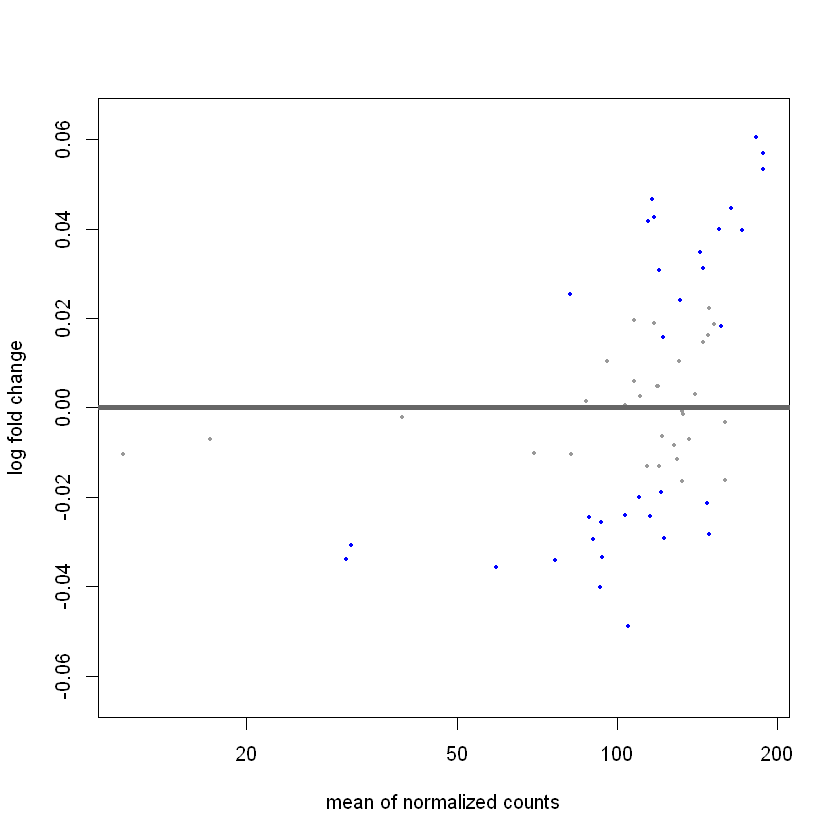

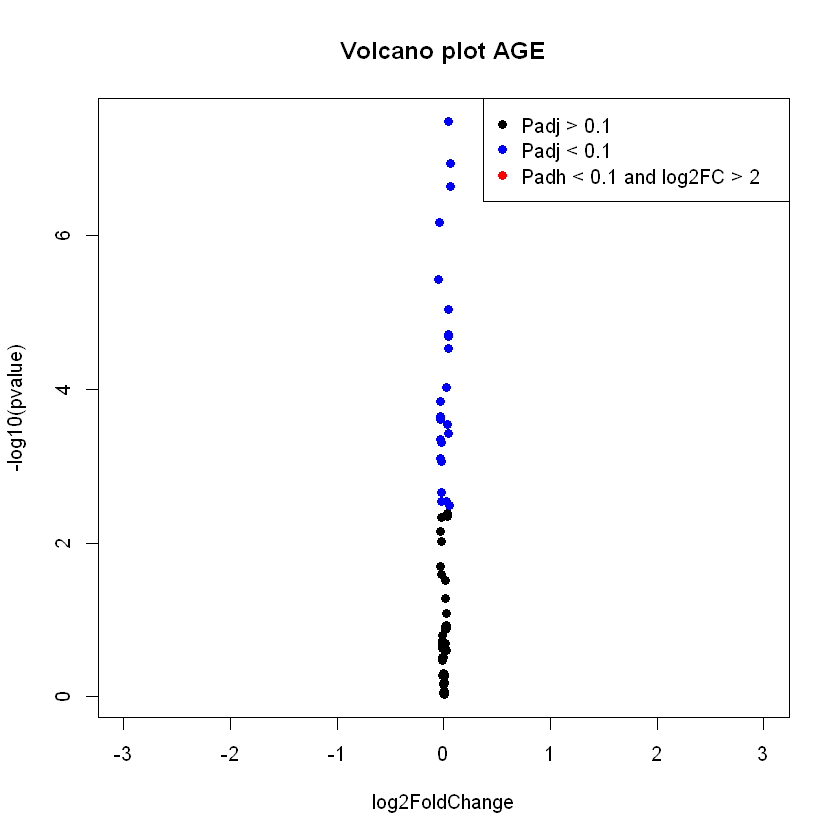

In [5]:
morph_analysis("AGE", ~ AGE, FALSE)

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing




out of 64 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 21, 33%
LFC < 0 (down)     : 6, 9.4%
outliers [1]       : 3, 4.7%
low counts [2]     : 0, 0%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



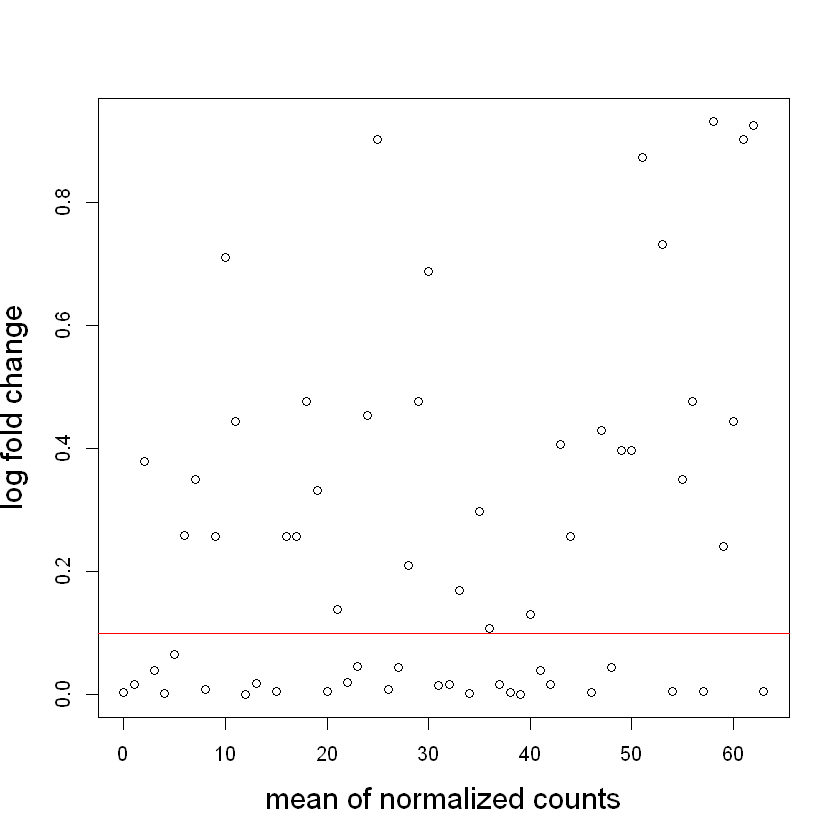

log2 fold change (MLE): HGHT 
Wald test p-value: HGHT 
DataFrame with 27 rows and 6 columns
     baseMean log2FoldChange     lfcSE      stat      pvalue        padj
    <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
39    149.278       0.328318 0.0712164   4.61015 4.02375e-06 0.000245449
12    188.915       0.406247 0.0928341   4.37606 1.20845e-05 0.000368577
4     143.581       0.240275 0.0631372   3.80560 1.41460e-04 0.002239627
34    121.015      -0.120143 0.0316472  -3.79632 1.46861e-04 0.002239627
38    119.988       0.201035 0.0559135   3.59546 3.23814e-04 0.003950533
...       ...            ...       ...       ...         ...         ...
41    88.5211      0.0959193 0.0392241   2.44542   0.0144684   0.0387172
27   163.8442     -0.1356962 0.0572904  -2.36857   0.0178572   0.0444201
48   116.5553      0.1382275 0.0585357   2.36142   0.0182050   0.0444201
23   152.3163     -0.1312906 0.0561324  -2.33894   0.0193384   0.0453708
5    159.5815     -0.0940403 0.0

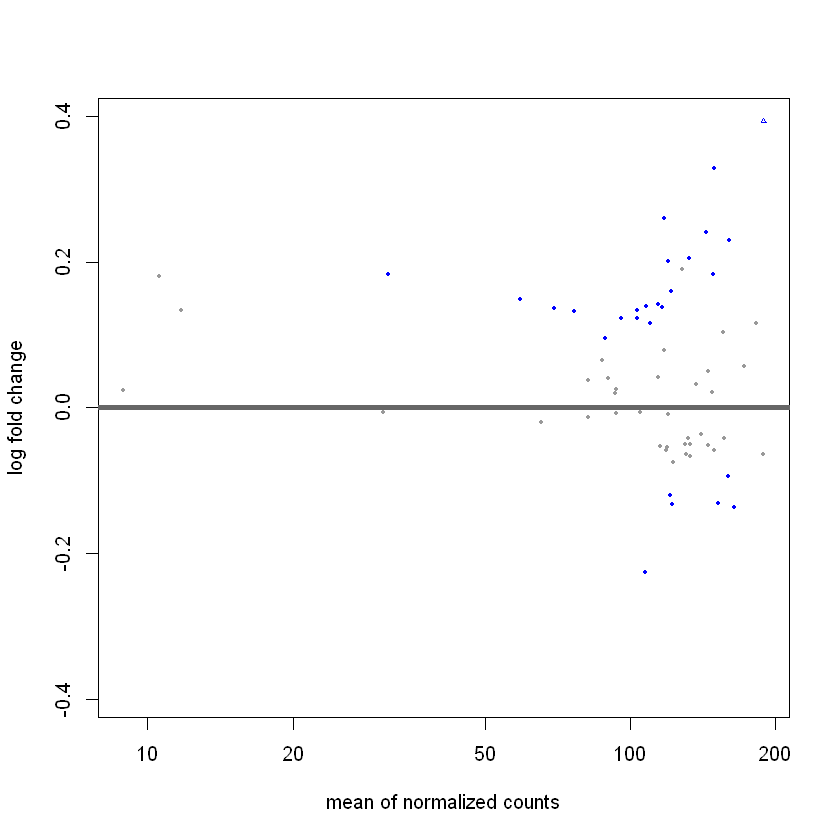

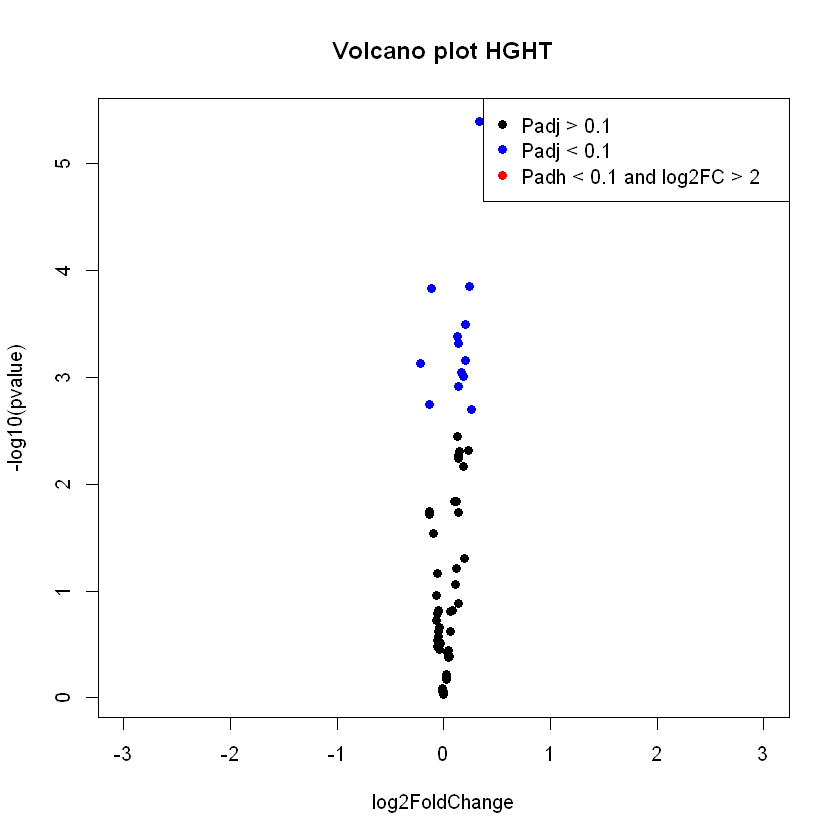

In [6]:
morph_analysis("HGHT", ~ HGHT, FALSE)

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing




out of 64 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 22, 34%
LFC < 0 (down)     : 6, 9.4%
outliers [1]       : 3, 4.7%
low counts [2]     : 0, 0%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



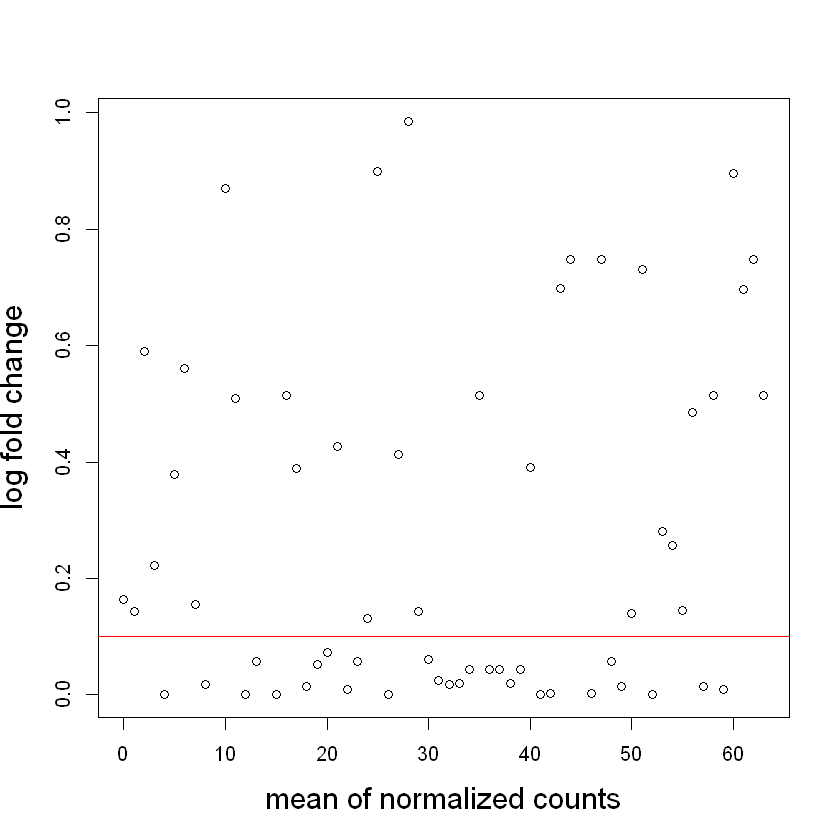

log2 fold change (MLE): WGHT 
Wald test p-value: WGHT 
DataFrame with 28 rows and 6 columns
     baseMean log2FoldChange      lfcSE      stat      pvalue        padj
    <numeric>      <numeric>  <numeric> <numeric>   <numeric>   <numeric>
26   117.5627      0.0328315 0.00689416   4.76222 1.91479e-06 0.000116802
15    69.6019      0.0151750 0.00345643   4.39038 1.13155e-05 0.000345121
4    143.5815      0.0222495 0.00523995   4.24613 2.17498e-05 0.000375165
12   188.9150      0.0329500 0.00786421   4.18987 2.79118e-05 0.000375165
52   110.6787     -0.0232640 0.00558179  -4.16783 3.07512e-05 0.000375165
...       ...            ...        ...       ...         ...         ...
13    76.3889     0.00918936 0.00403013   2.28016   0.0225980   0.0574365
23   152.3163    -0.01060767 0.00469755  -2.25813   0.0239377   0.0574740
48   116.5553     0.01102434 0.00490136   2.24924   0.0244971   0.0574740
30   147.6561     0.00739387 0.00334548   2.21011   0.0270978   0.0612209
20   121.3658     0.

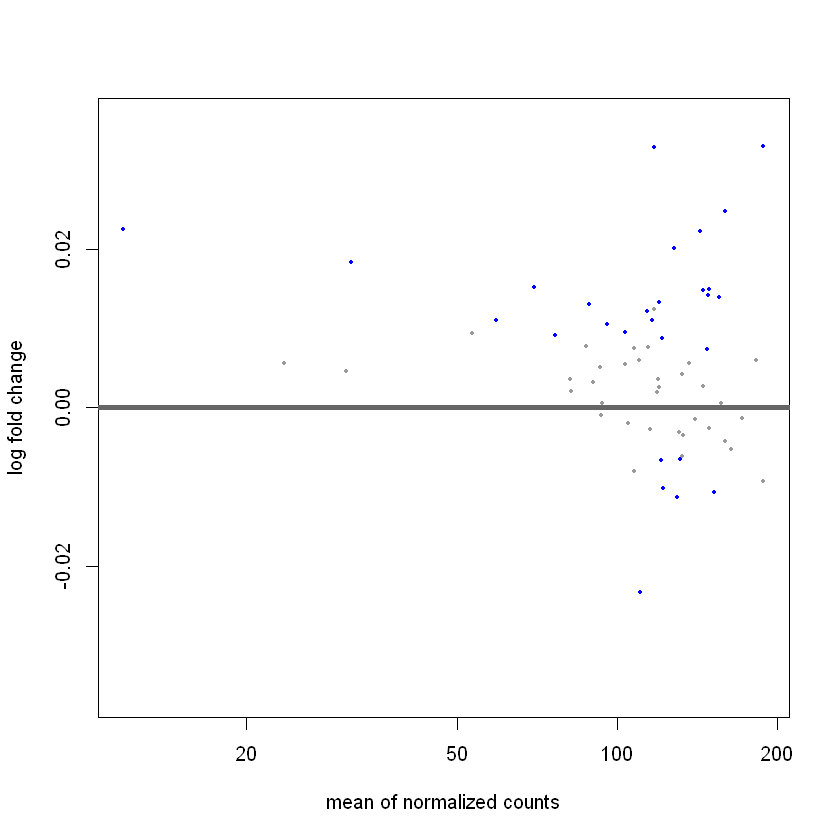

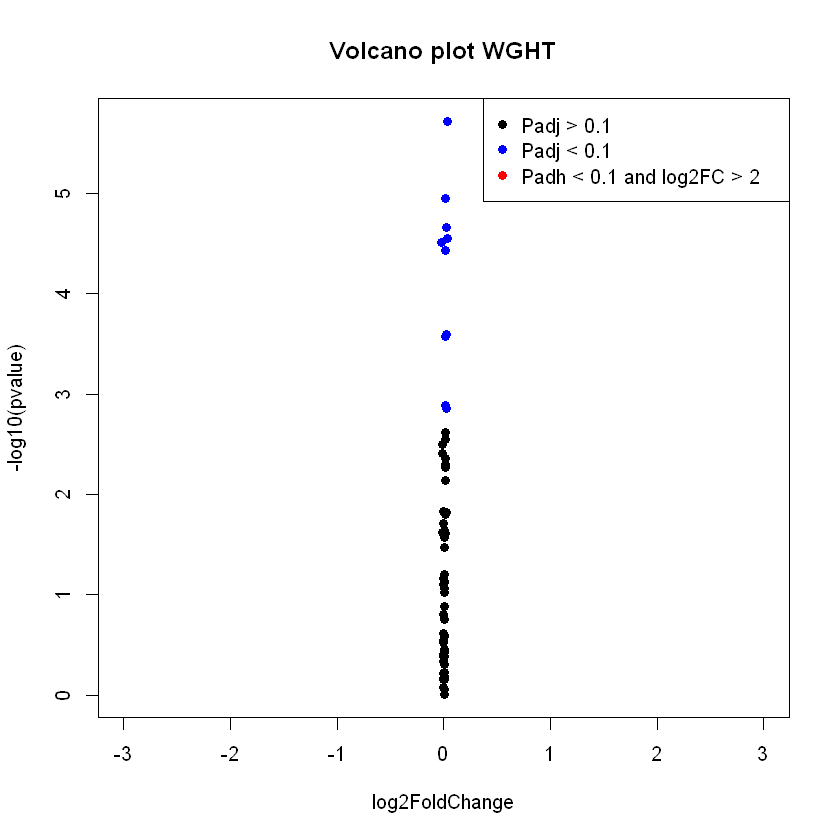

In [7]:
morph_analysis("WGHT", ~ WGHT, FALSE)

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing




out of 64 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 9, 14%
LFC < 0 (down)     : 2, 3.1%
outliers [1]       : 3, 4.7%
low counts [2]     : 0, 0%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



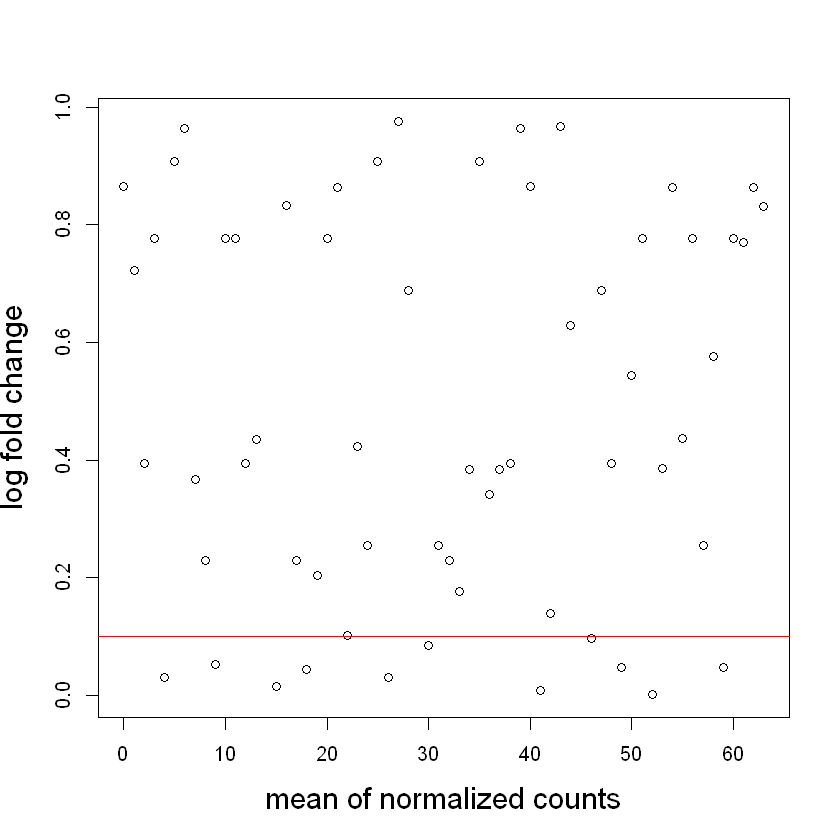

log2 fold change (MLE): BMI 
Wald test p-value: BMI 
DataFrame with 11 rows and 6 columns
    baseMean log2FoldChange     lfcSE      stat      pvalue        padj
   <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
52  110.6787     -0.1673596 0.0385012  -4.34687 1.38094e-05 0.000842374
41   88.5211      0.0810352 0.0220930   3.66791 2.44544e-04 0.007458596
15   69.6019      0.0829513 0.0244761   3.38908 7.01274e-04 0.014259233
4   143.5815      0.1126313 0.0368903   3.05314 2.26459e-03 0.030170785
26  117.5627      0.1467005 0.0484700   3.02662 2.47302e-03 0.030170785
18  145.3042      0.0970766 0.0340512   2.85090 4.35951e-03 0.044321691
49  129.8455     -0.0723951 0.0264861  -2.73333 6.26977e-03 0.047806991
59   11.7334      0.1347199 0.0489635   2.75143 5.93350e-03 0.047806991
9   117.5544      0.0827994 0.0310794   2.66412 7.71898e-03 0.052317535
30  147.6561      0.0567178 0.0230453   2.46115 1.38494e-02 0.084481396
46   95.8441      0.0483531 0.0203478   2.3763

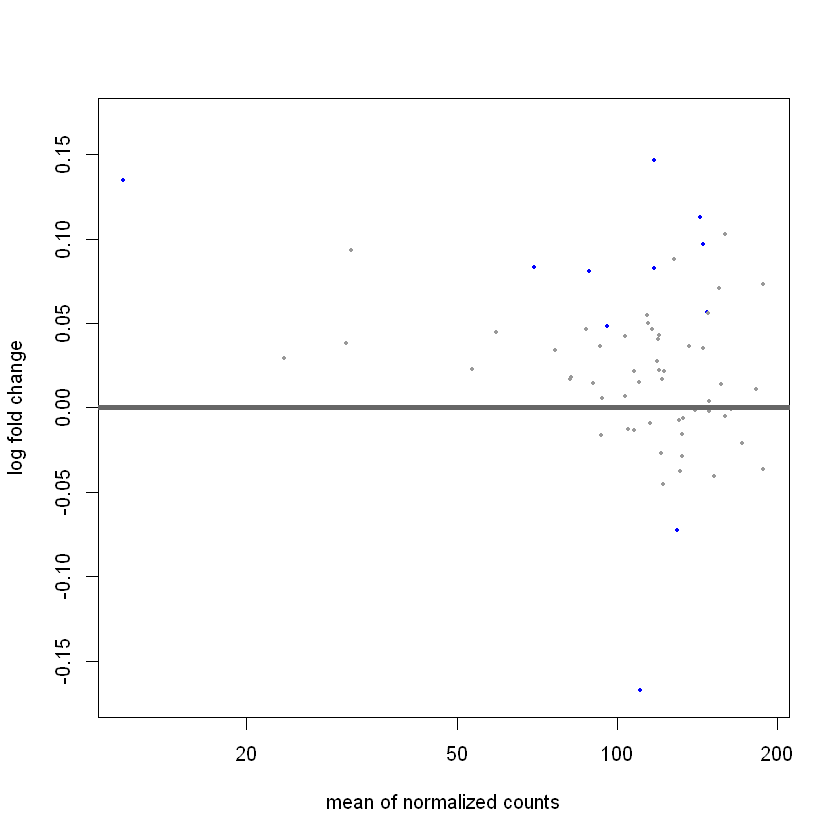

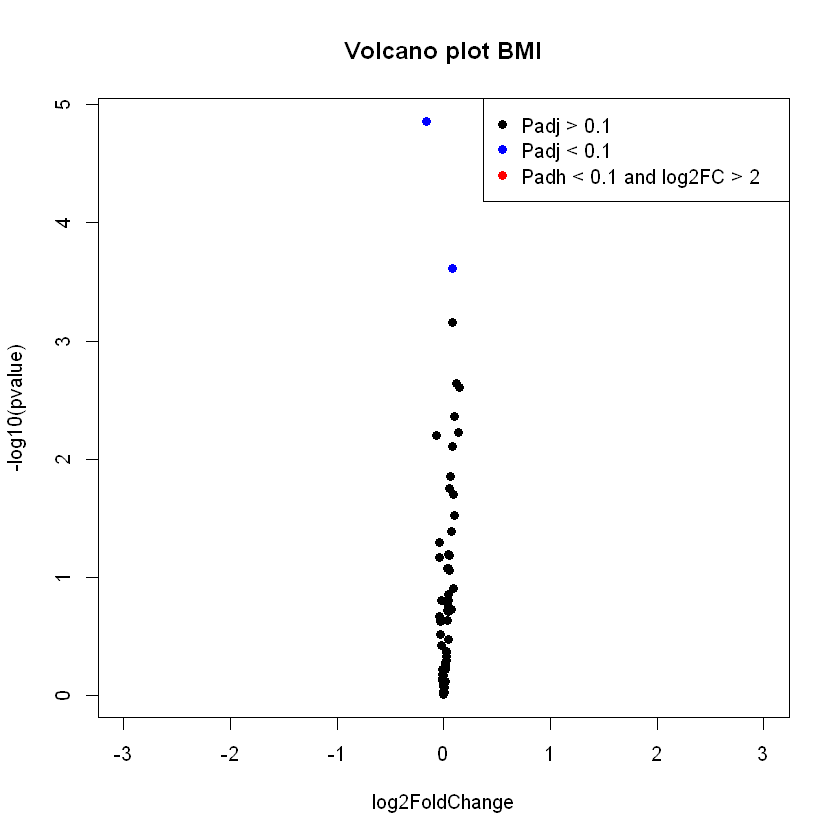

In [8]:
morph_analysis("BMI", ~BMI, FALSE)

### Q2.2 - Technical variables vs. morphology

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
 


out of 64 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 25, 39%
LFC < 0 (down)     : 25, 39%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



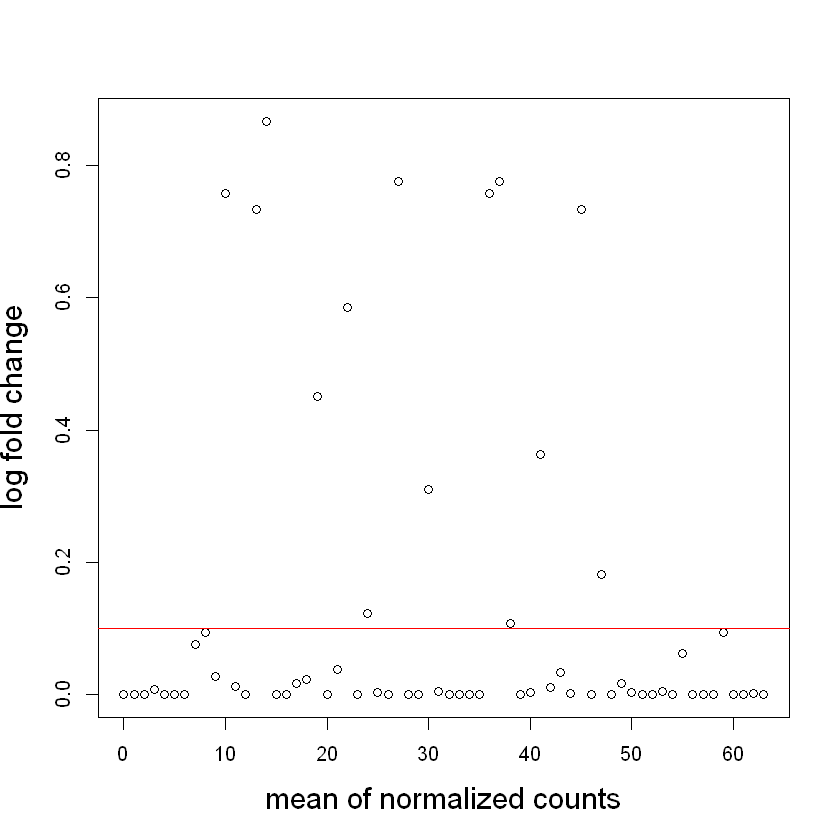

log2 fold change (MLE): COHORT Postmortem vs Organ.Donor..OPO. 
Wald test p-value: COHORT Postmortem vs Organ.Donor..OPO. 
DataFrame with 50 rows and 6 columns
     baseMean log2FoldChange     lfcSE      stat      pvalue        padj
    <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
57    148.241        2.34432  0.217897  10.75884 5.38421e-27 3.44589e-25
33    155.450        2.41645  0.236885  10.20096 1.96322e-24 6.28231e-23
48    116.555        2.28969  0.233212   9.81806 9.41351e-23 2.00822e-21
12    188.915        3.79242  0.400244   9.47527 2.66064e-21 4.25703e-20
35    133.194       -1.90066  0.201448  -9.43501 3.90950e-21 5.00417e-20
...       ...            ...       ...       ...         ...         ...
21   130.7797      -0.371828  0.168324  -2.20901   0.0271740   0.0378073
55   132.8157       0.402014  0.201139   1.99869   0.0456419   0.0621507
7     87.3322      -0.495374  0.260611  -1.90082   0.0573260   0.0764347
8    121.9710      -0.367821  0.20535

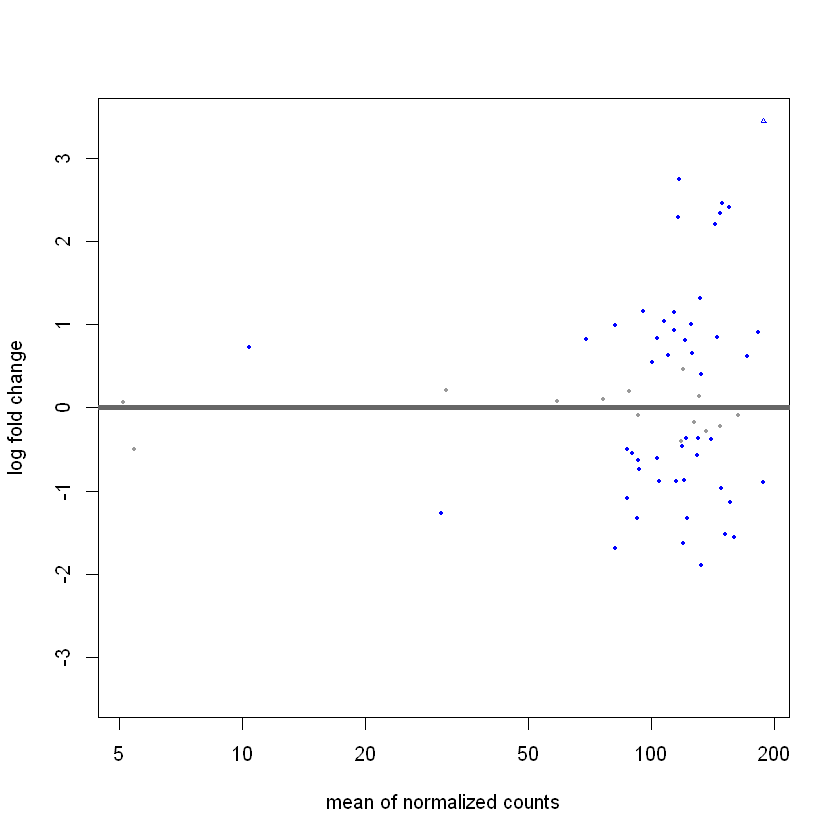

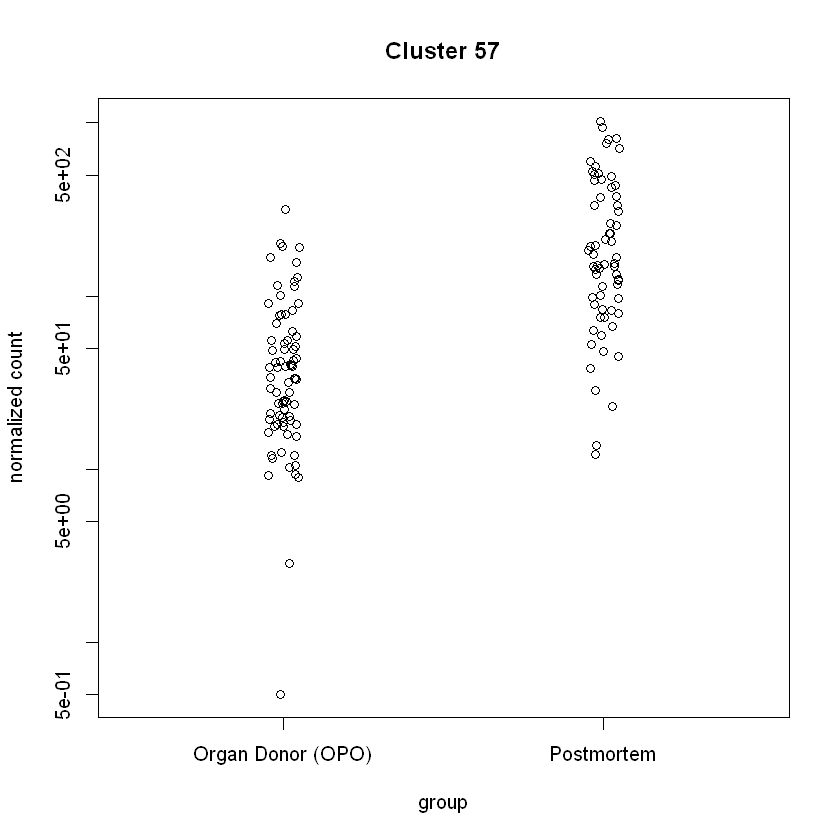

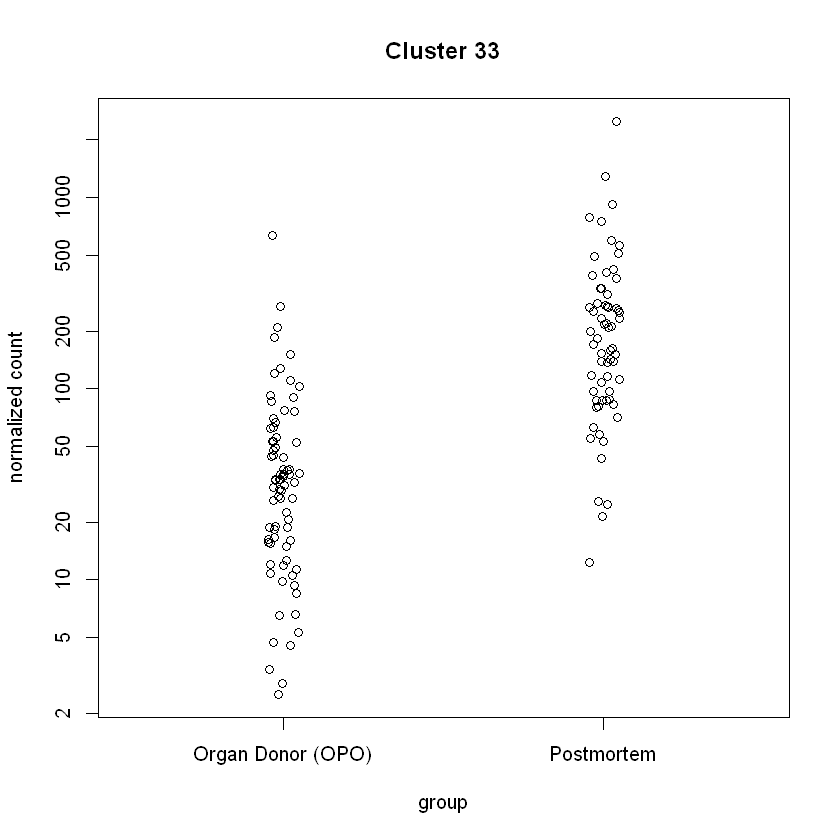

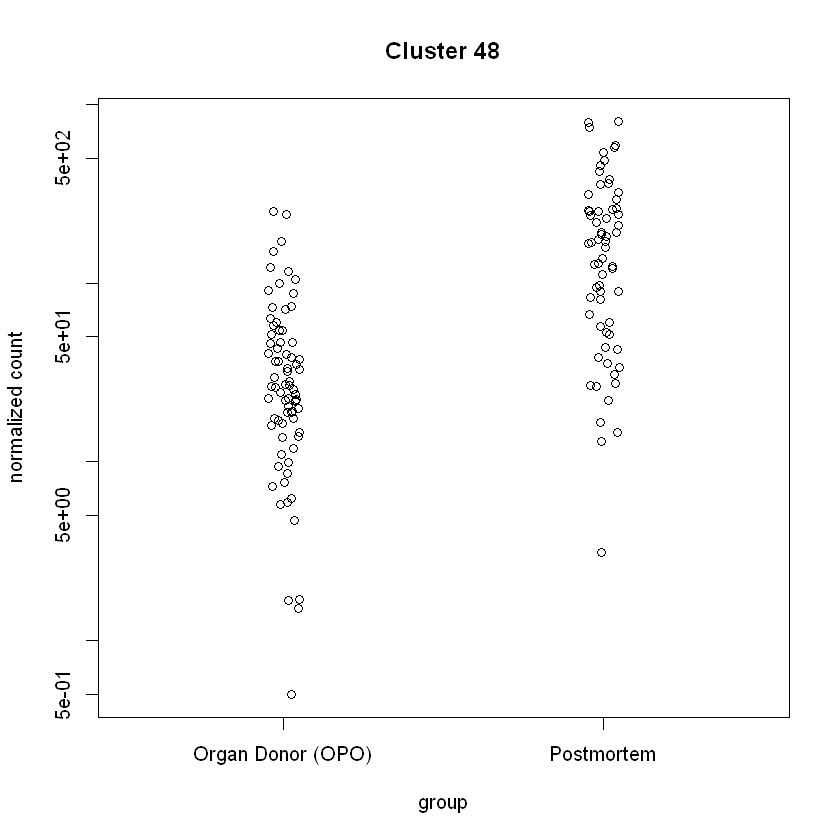

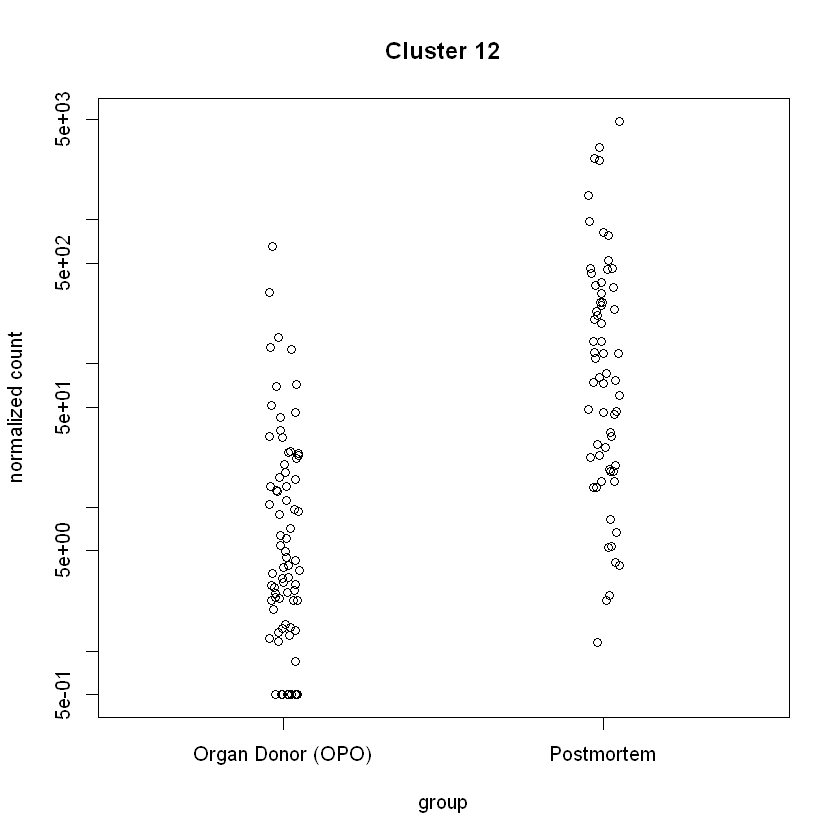

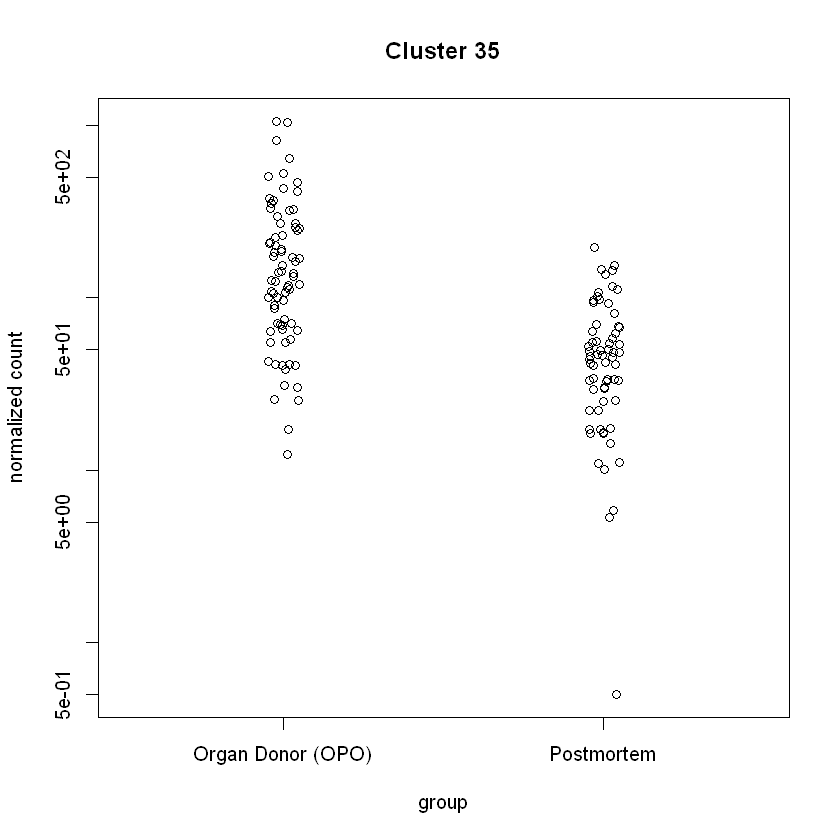

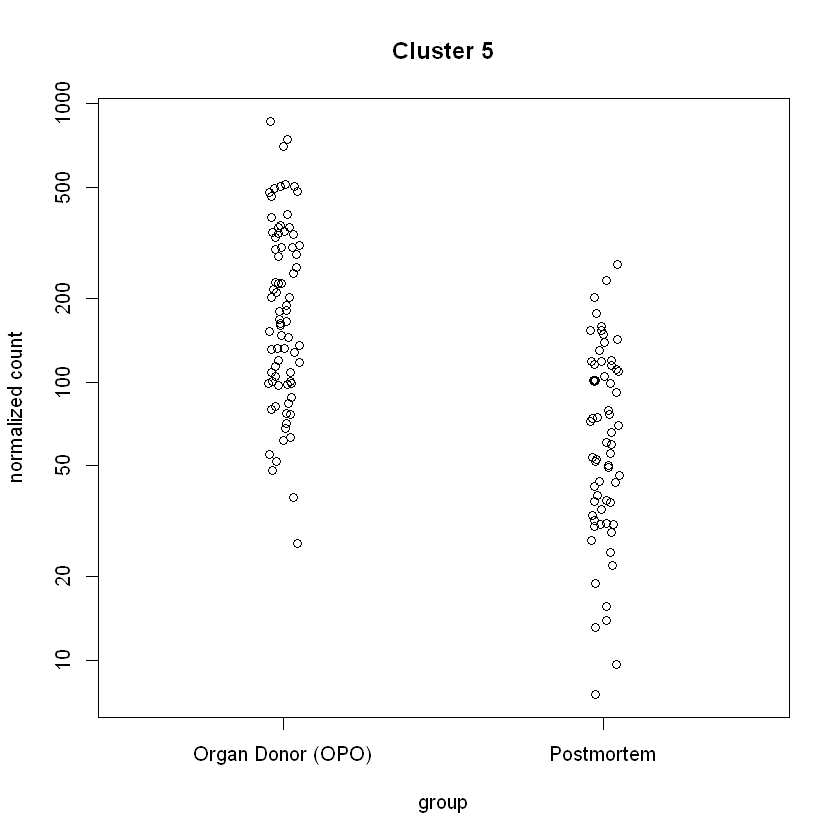

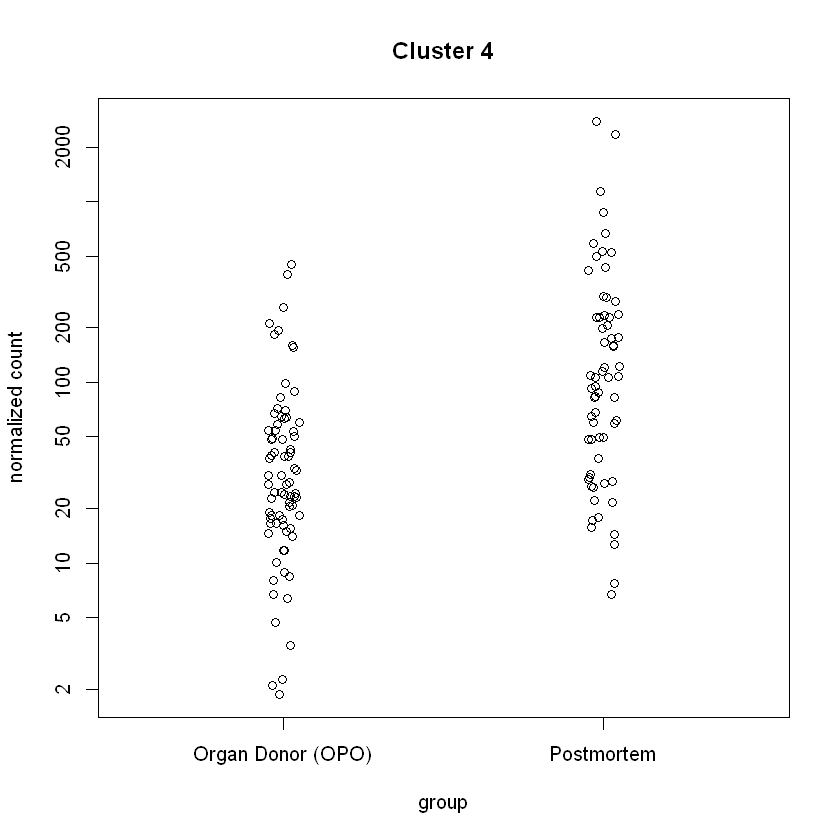

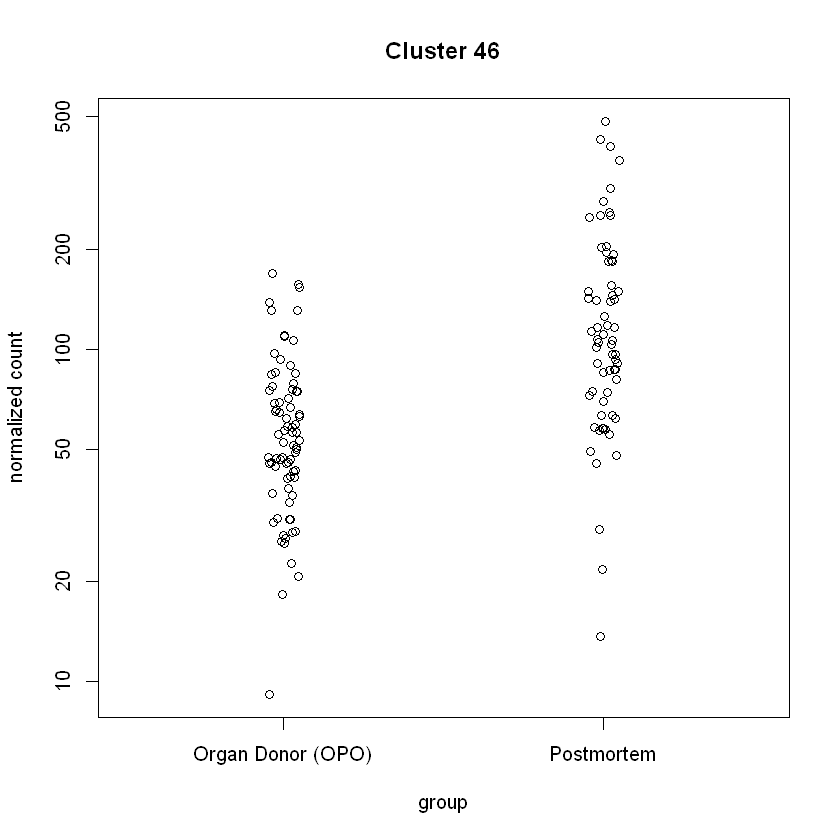

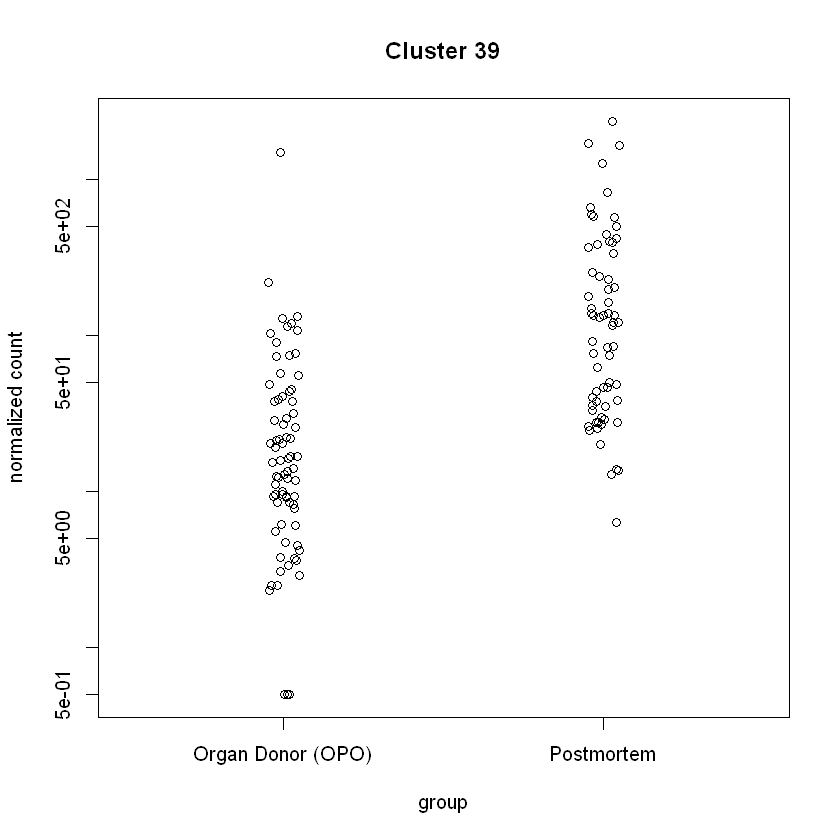

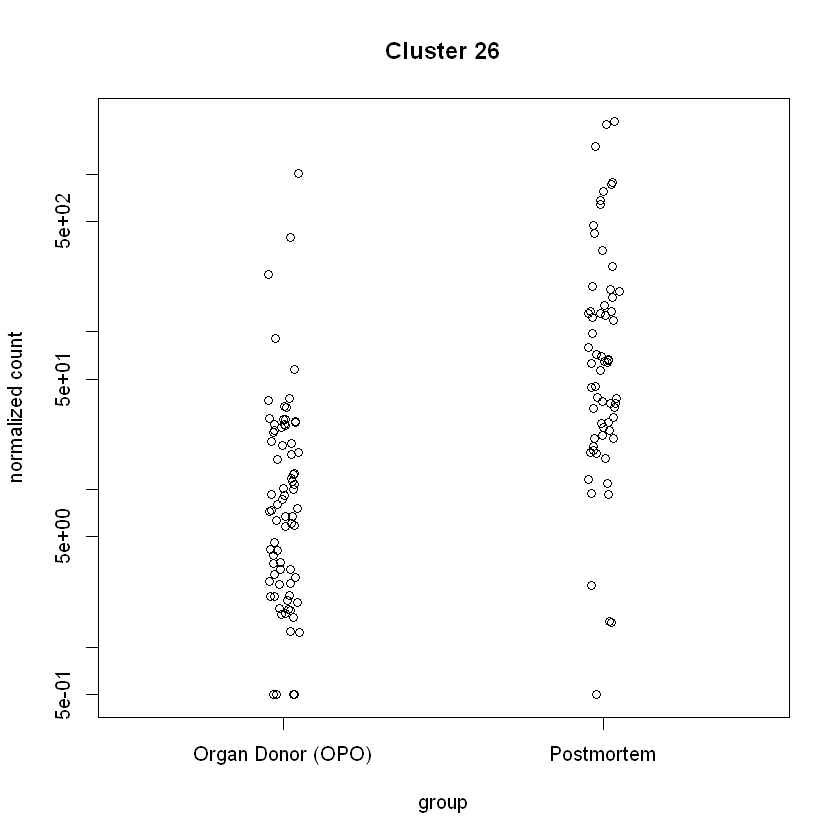

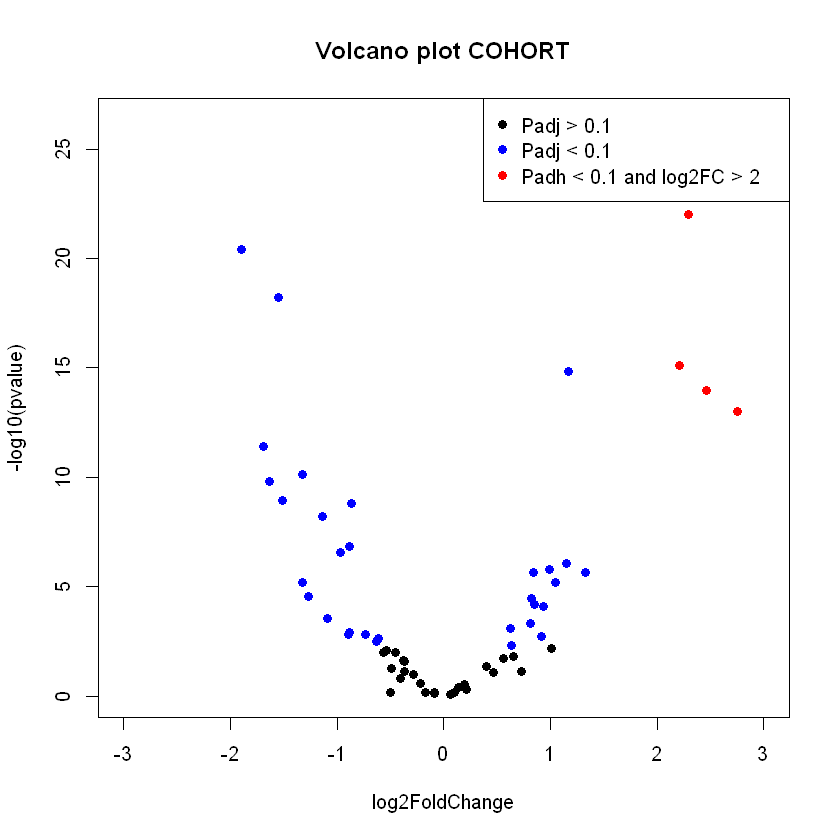

In [9]:
morph_analysis("COHORT", ~ COHORT, TRUE)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing




out of 64 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 15, 23%
LFC < 0 (down)     : 20, 31%
outliers [1]       : 1, 1.6%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



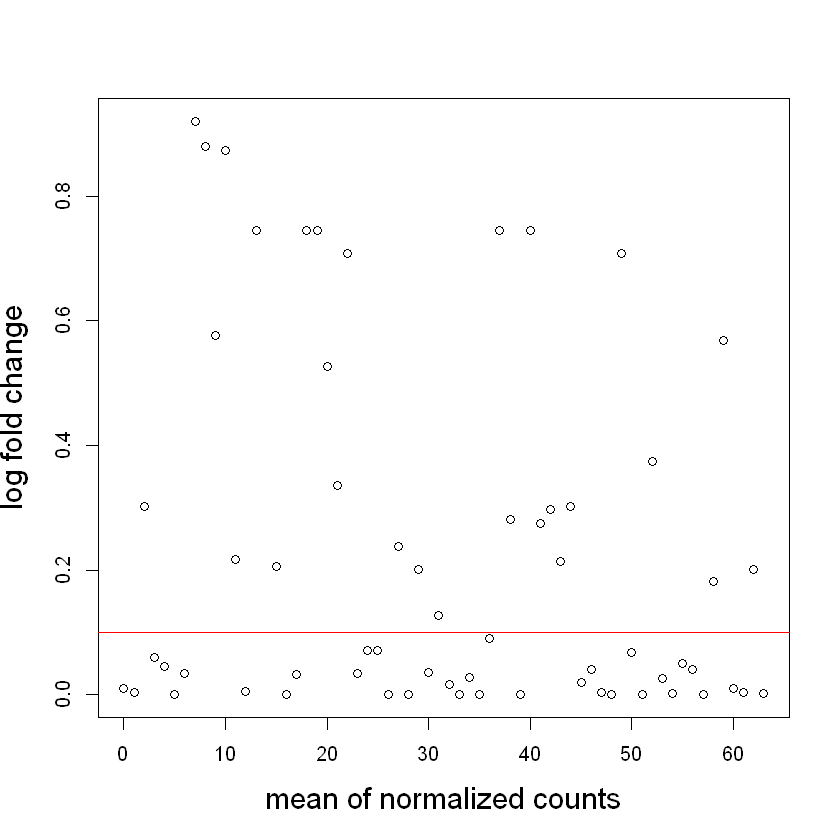

log2 fold change (MLE): DTHHRDY 4 vs 0 
Wald test p-value: DTHHRDY 4 vs 0 
DataFrame with 35 rows and 6 columns
     baseMean log2FoldChange     lfcSE      stat      pvalue        padj
    <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
28    122.696       -1.87755  0.302180  -6.21333 5.18725e-10 1.97544e-08
35    133.194       -1.93637  0.313153  -6.18346 6.27125e-10 1.97544e-08
33    155.450        1.97710  0.368779   5.36120 8.26727e-08 1.73613e-06
5     159.582       -1.41964  0.269473  -5.26820 1.37765e-07 2.16980e-06
57    148.241        1.69382  0.338032   5.01083 5.41955e-07 6.82863e-06
...       ...            ...       ...       ...         ...         ...
3    110.1487       0.744137  0.341941   2.17622   0.0295390   0.0600309
50   188.2888      -0.902298  0.426150  -2.11733   0.0342322   0.0673946
24   136.7598      -0.550904  0.264670  -2.08147   0.0373905   0.0710444
25    93.5703      -0.727940  0.351461  -2.07119   0.0383414   0.0710444
36   127.937

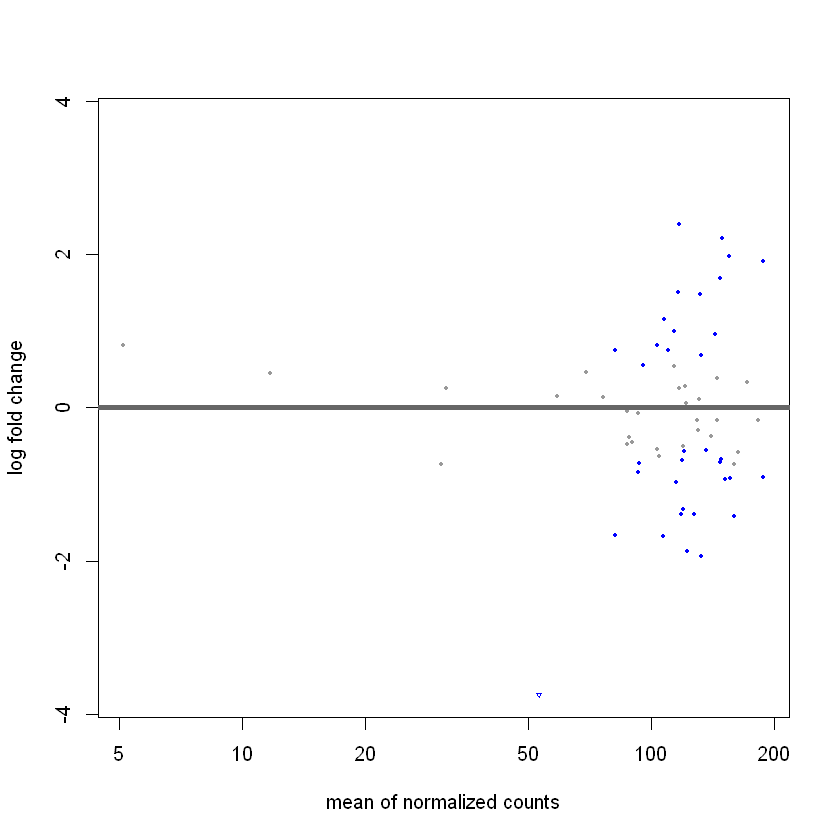

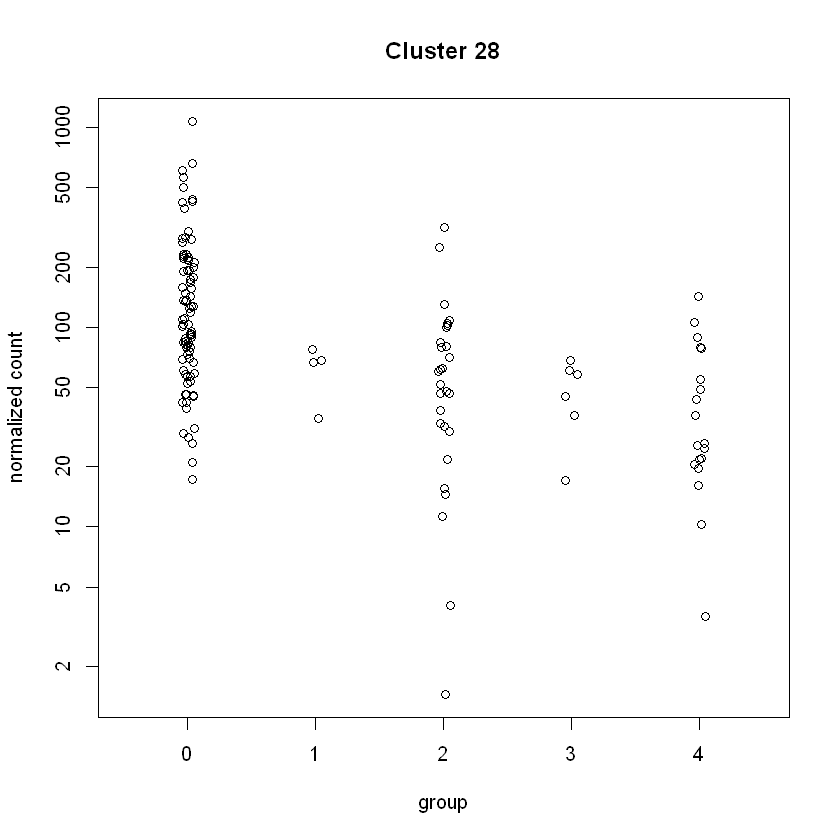

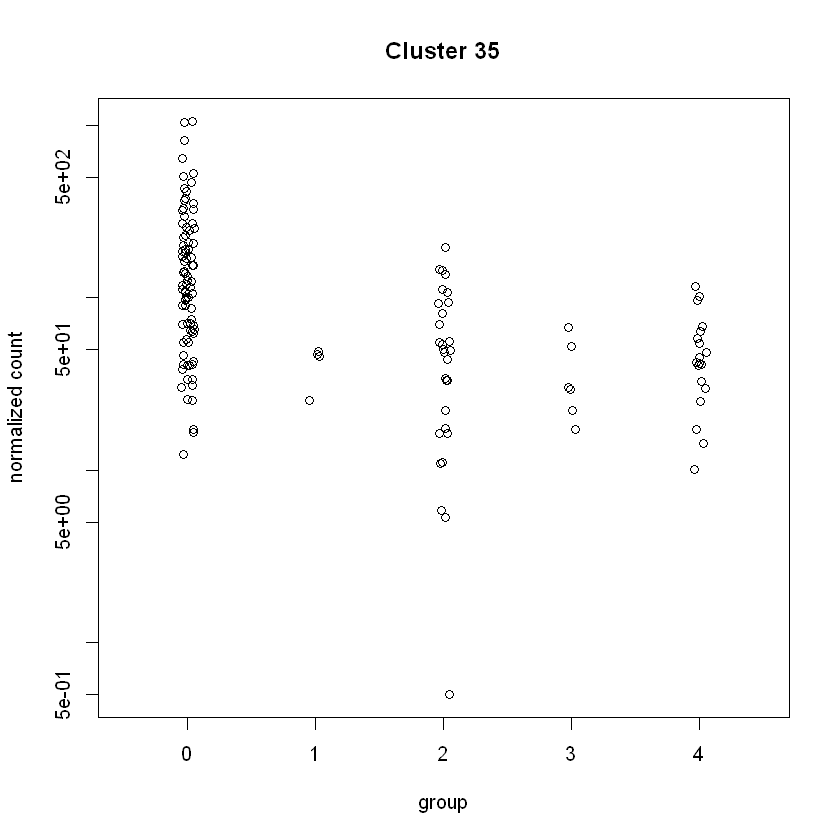

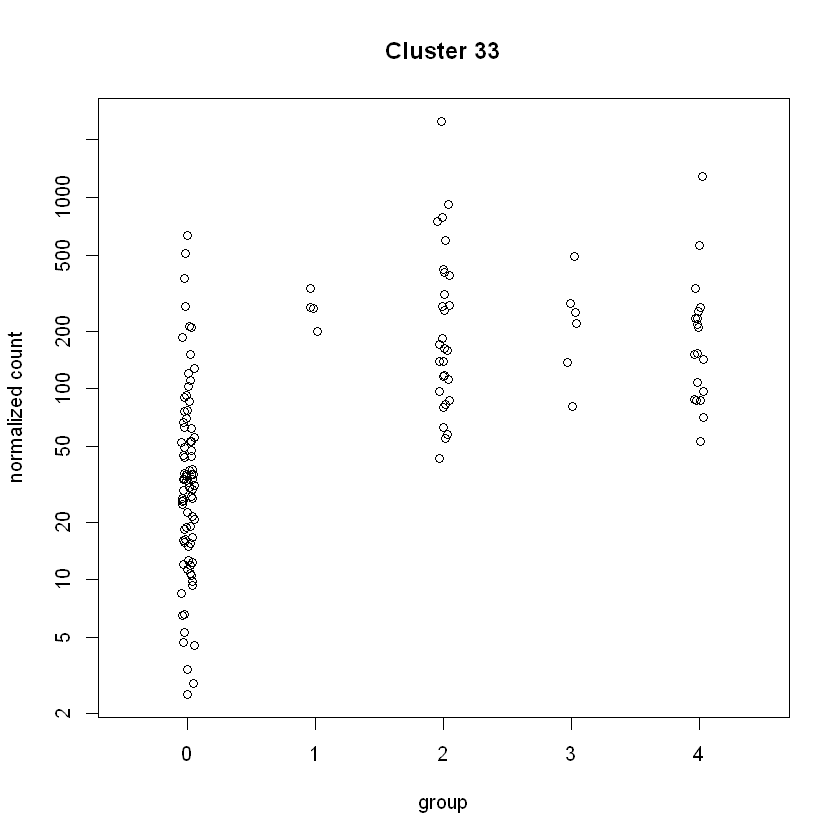

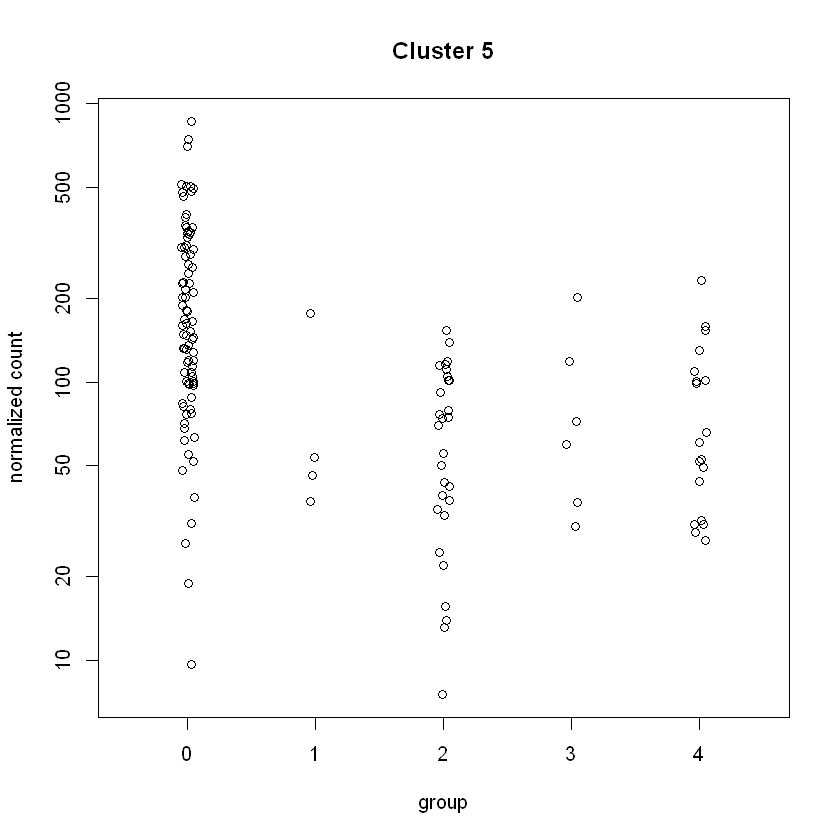

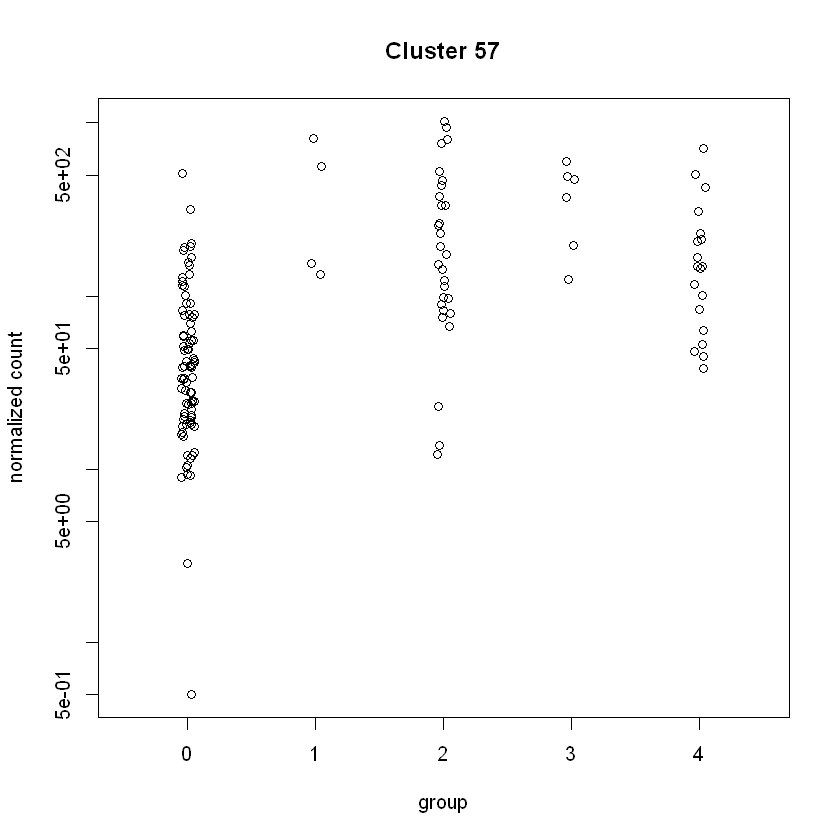

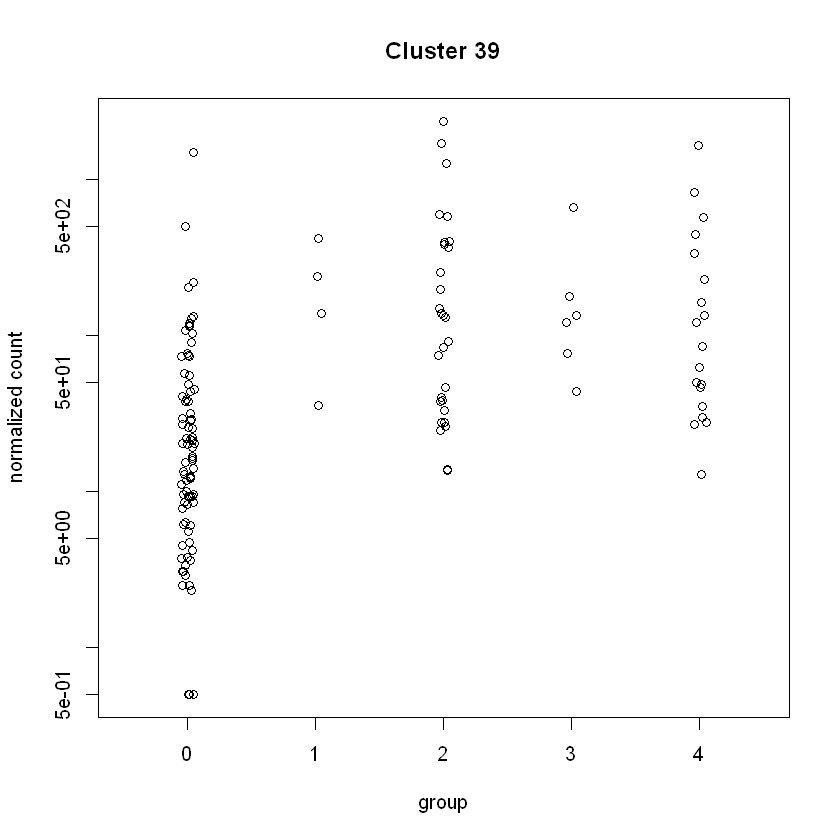

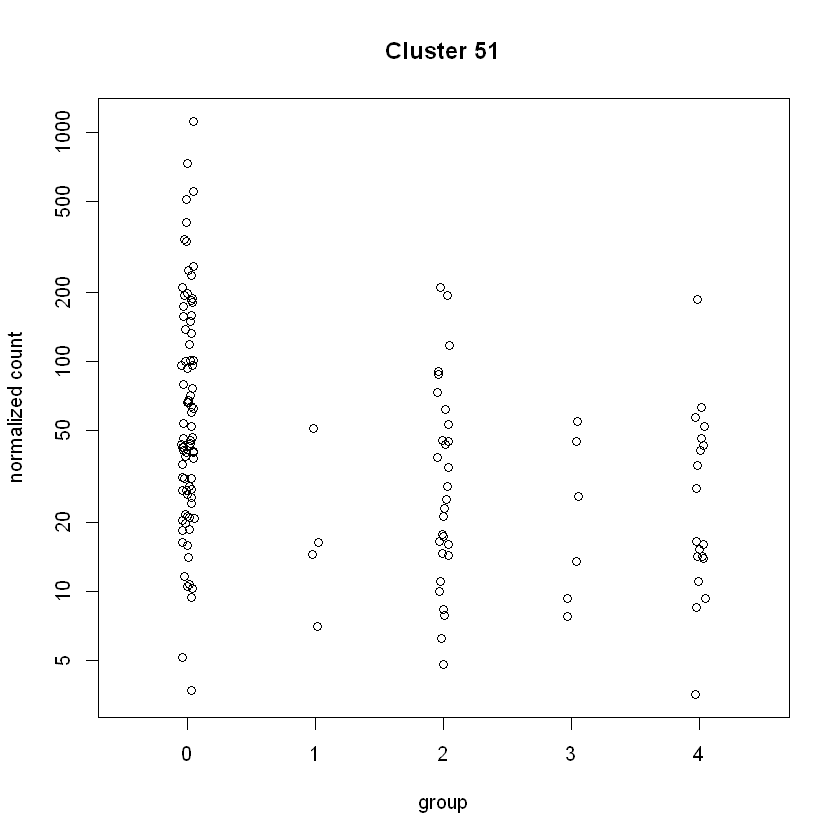

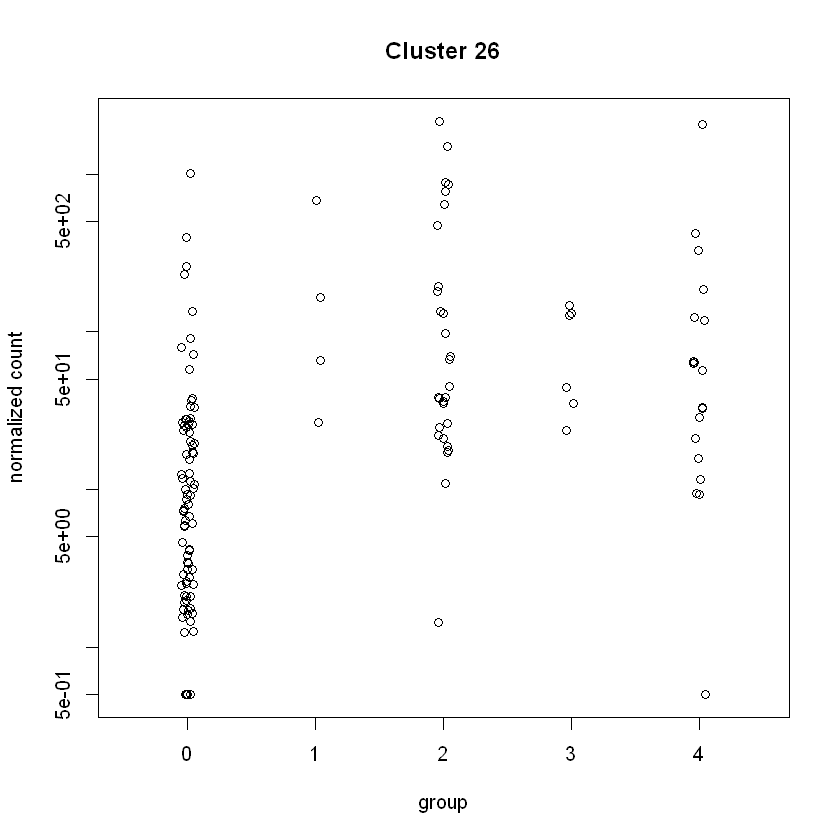

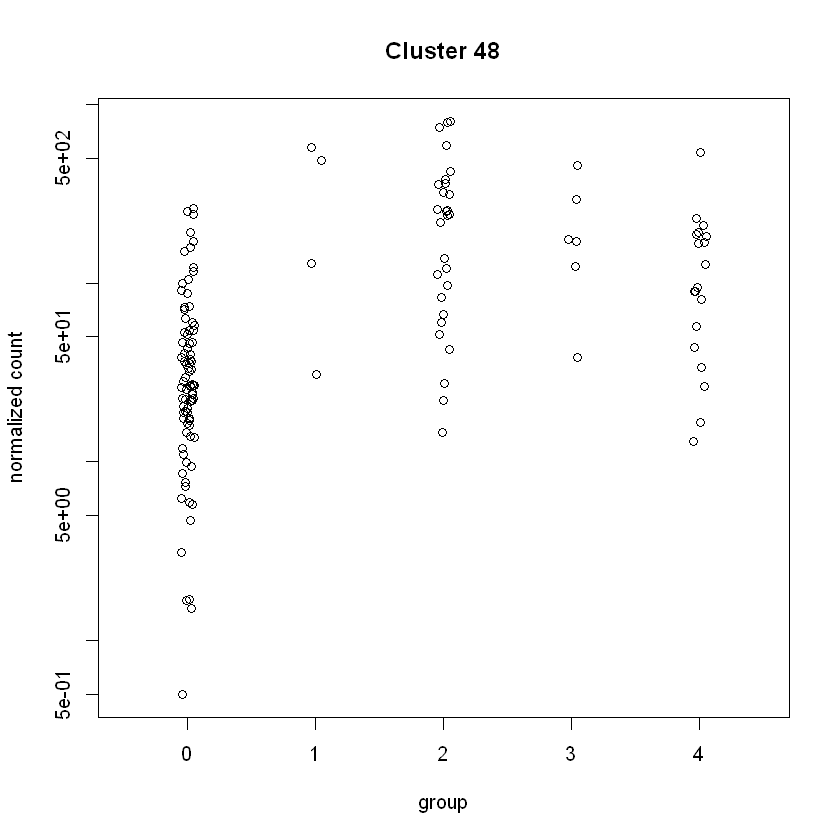

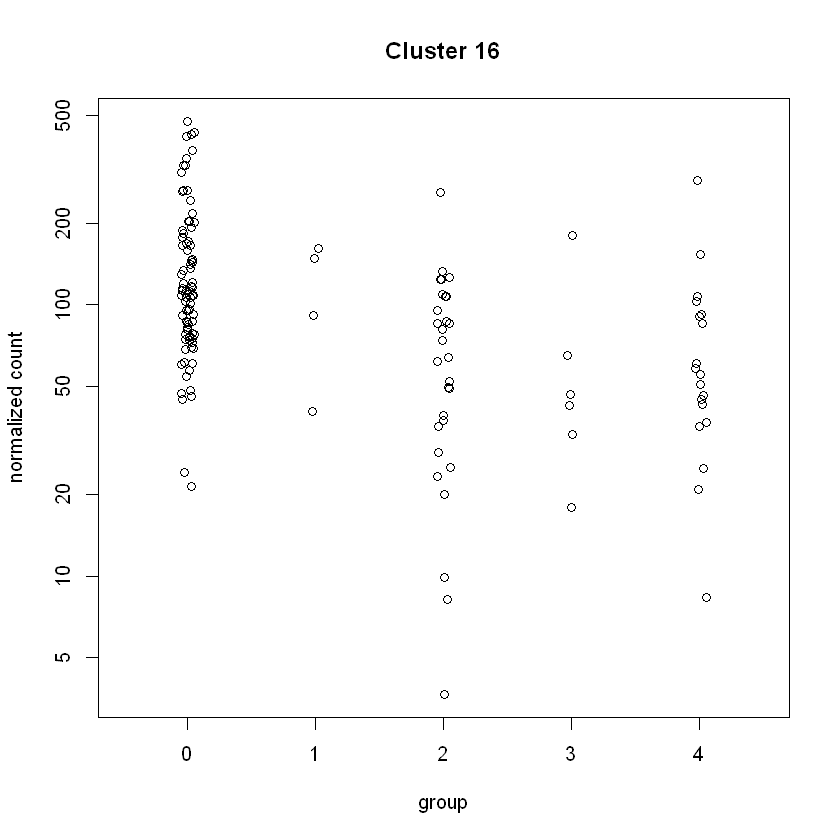

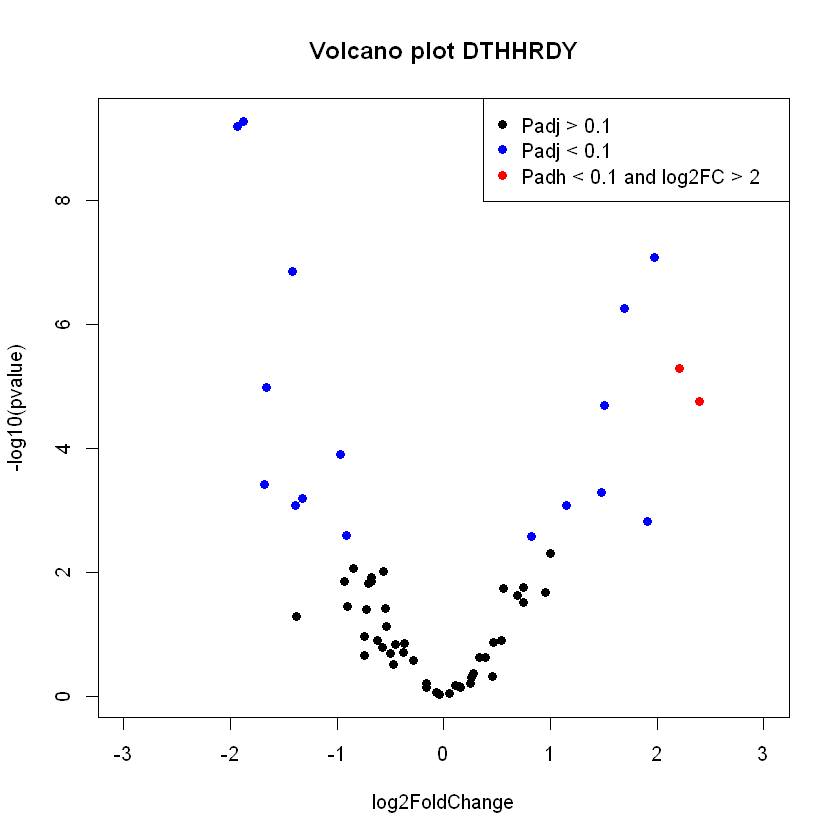

In [10]:
morph_analysis("DTHHRDY", ~ DTHHRDY, TRUE)

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 64 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 22, 34%
LFC < 0 (down)     : 23, 36%
outliers [1]       : 1, 1.6%
low counts [2]     : 0, 0%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



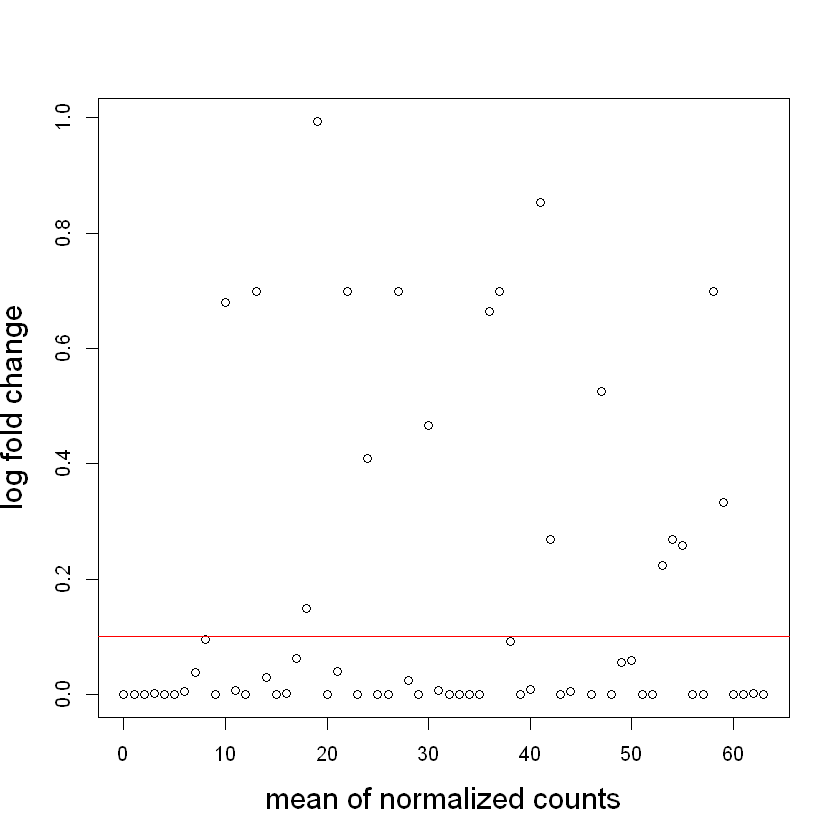

log2 fold change (MLE): TRISCHD 
Wald test p-value: TRISCHD 
DataFrame with 45 rows and 6 columns
     baseMean log2FoldChange       lfcSE      stat      pvalue        padj
    <numeric>      <numeric>   <numeric> <numeric>   <numeric>   <numeric>
33    155.450     0.00325618 0.000272450  11.95146 6.37969e-33 4.01921e-31
39    149.278     0.00400691 0.000355038  11.28587 1.54108e-29 4.85442e-28
57    148.241     0.00282808 0.000268215  10.54408 5.40976e-26 1.13605e-24
26    117.563     0.00418936 0.000416295  10.06346 8.01293e-24 1.26204e-22
12    188.915     0.00432234 0.000486819   8.87874 6.76204e-19 8.52017e-18
...       ...            ...         ...       ...         ...         ...
49    129.846   -0.000556135 0.000266138  -2.08965   0.0366495   0.0563151
50    188.289   -0.000701417 0.000340991  -2.05700   0.0396866   0.0595300
17    119.358   -0.000435820 0.000215123  -2.02590   0.0427745   0.0626697
38    119.988    0.000600854 0.000325205   1.84761   0.0646583   0.0925789
8 

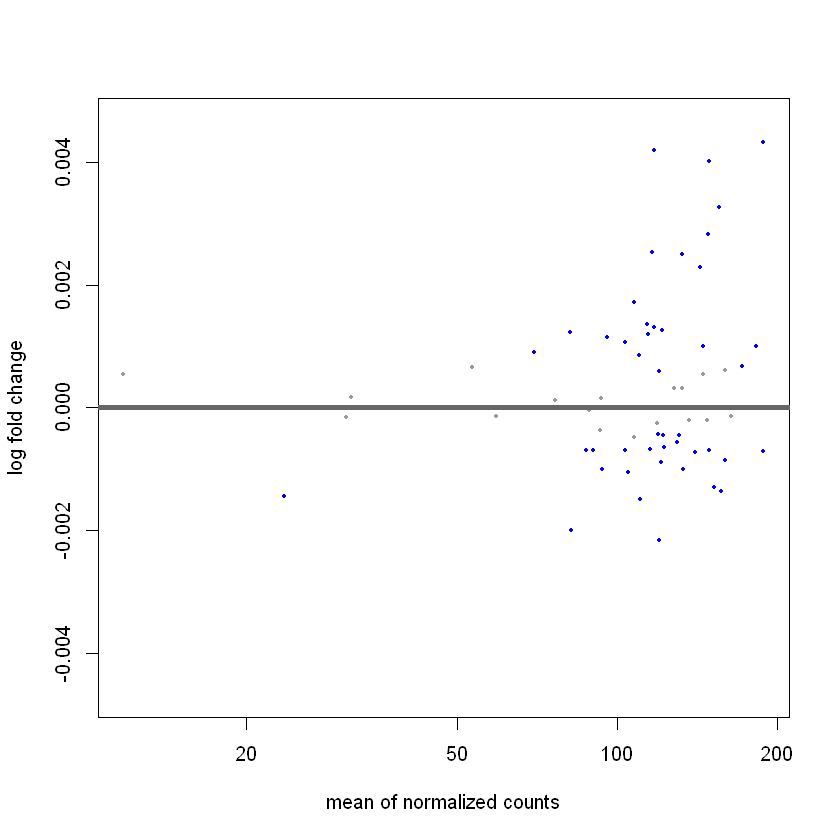

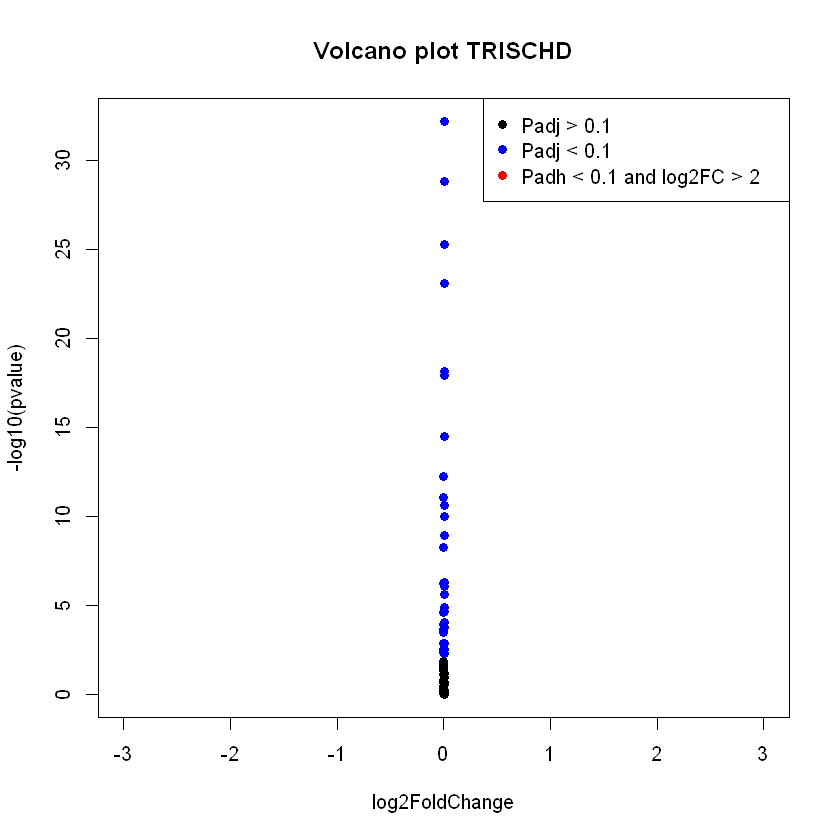

In [11]:
morph_analysis("TRISCHD", ~TRISCHD, FALSE)

### Q2.3 - Accounting for confounding variables
In the previous section, we only analysed one clinical variable at a time. Now, we account for confounding variables by using formulas of the form "VAR + X + Y", where the multivariate association of morphological clusters with variables VAR are calculated adjusted for the variations of X and Y. The rest of the analysis remains the same. We start off with the AGE variable, which we found in the previous section to be confounded by TRISCHD and COHORT.

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names i


out of 64 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 12, 19%
LFC < 0 (down)     : 14, 22%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



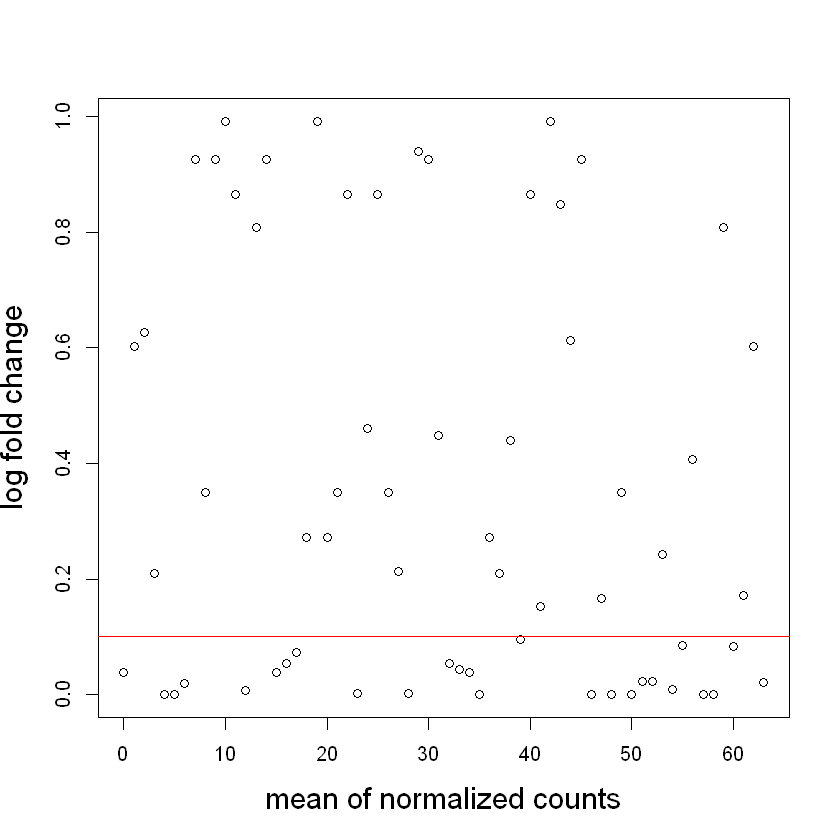

log2 fold change (MLE): COHORT Postmortem vs Organ.Donor..OPO. 
Wald test p-value: COHORT Postmortem vs Organ.Donor..OPO. 
DataFrame with 26 rows and 6 columns
     baseMean log2FoldChange     lfcSE      stat      pvalue        padj
    <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
35   133.1940       -2.04221  0.315686  -6.46913 9.85679e-11 6.30835e-09
5    159.5815       -1.62150  0.277740  -5.83821 5.27648e-09 1.68847e-07
46    95.8441        1.22837  0.229510   5.35215 8.69176e-08 1.43065e-06
57   148.2410        1.79120  0.334990   5.34702 8.94153e-08 1.43065e-06
4    143.5815        1.90185  0.432813   4.39416 1.11203e-05 1.42339e-04
...       ...            ...       ...       ...         ...         ...
32    114.069       0.839467  0.355828   2.35919   0.0183147   0.0532793
17    119.358      -0.623102  0.280782  -2.21917   0.0264753   0.0736705
60    156.779      -0.643167  0.298965  -2.15131   0.0314517   0.0838712
55    132.816       0.673227  0.31619

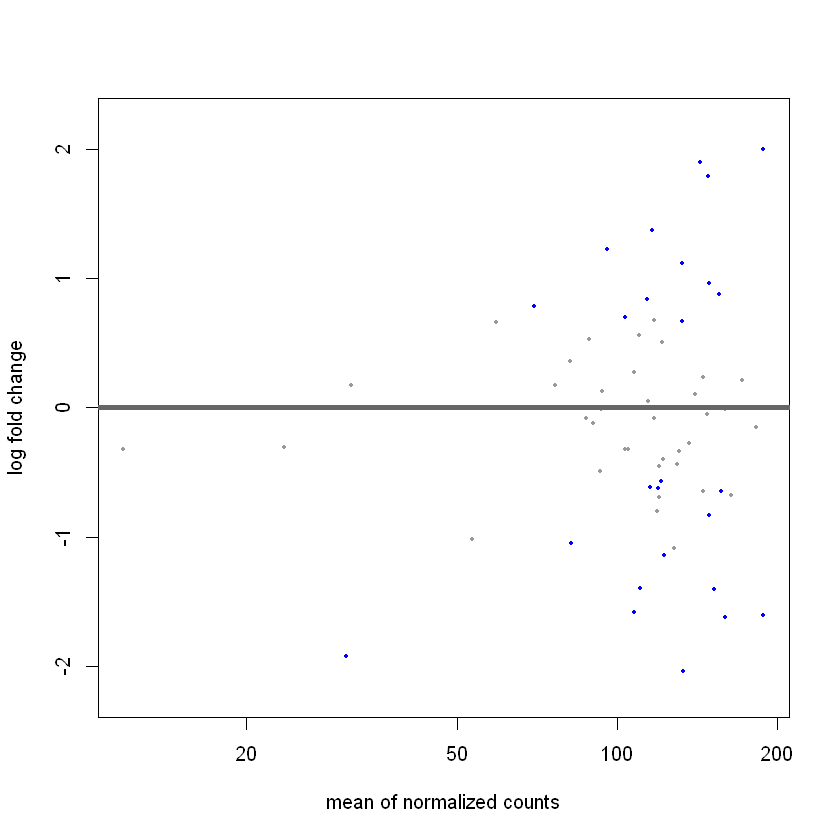

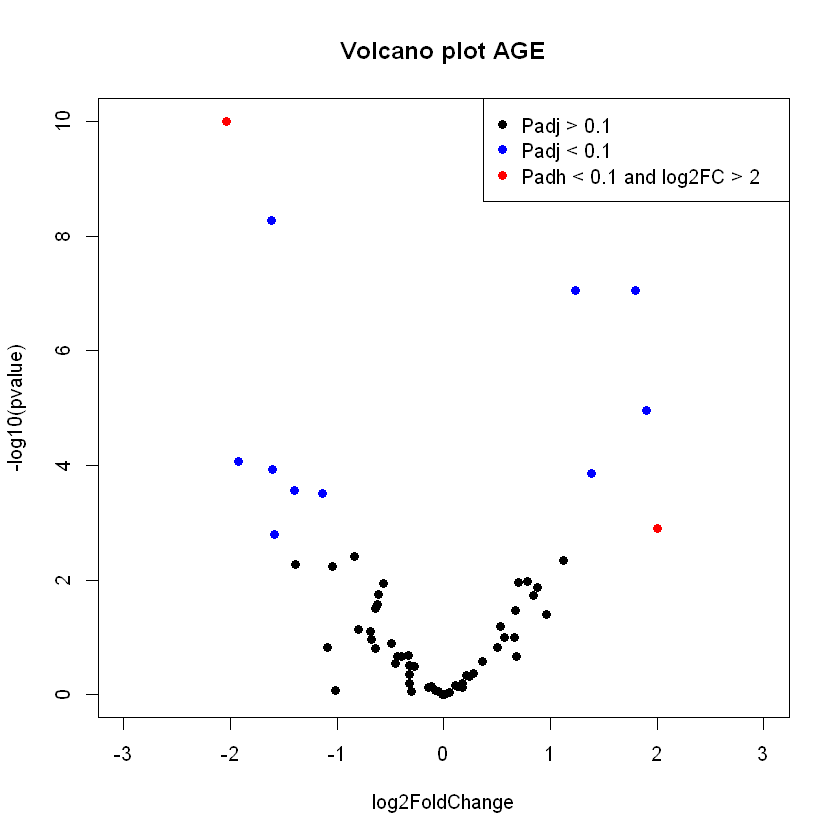

In [20]:
morph_analysis("AGE", ~AGE + TRISCHD + COHORT, FALSE, TRUE)

In [ ]:
#TODO: weight, height, (bmi?)